In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

## systematic test 

In [2]:
import numpy as np
import healpy as hp

footmask=hp.read_map('/n/des/lee.5922/data/gold_cat/mask/y1a1_gold_1.0.2_wide_footprint_4096.fits.gz')
badmask=hp.read_map('/n/des/lee.5922/data/gold_cat/mask/y1a1_gold_1.0.3_wide_badmask_4096.fits.gz',dtype=np.int32)

ipring,=np.where((footmask >= 1) & ((badmask & (64+32+8)) == 0))

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [ ]:
reddening_nest = esutil.io.read('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv.fits', ensure_native=True)
reddening_ring = hp.reorder(reddening_nest['TEMPERATURE'], inp='NEST', out='RING')
reddening = rotate_hp_map(reddening_ring, coord = ['C', 'G'])

In [225]:
fitsio.write('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv_galactic_coord.fits', reddening)

In [241]:
# calling catalog
#from systematics import GalaxyDensity_Systematics,loadSystematicMaps, chisquare_dof, MatchHPArea, SysMapBadRegionMask, callingEliGoldMask

def calling_sysMap( properties=None, kind='SPT', nside=4096, path = None ):
    # Calling maps
    from systematics import callingEliGoldMask,callingY1GoldMask
    GoldMask = callingEliGoldMask()
    #GoldMask = callingY1GoldMask(nside)
    
    MaskDic = {}
    for i,p in enumerate(properties):
        if p == 'NSTARS_allband':
            filename =  'y1a1_gold_1.0.2_stars_nside1024.fits'
            sysMap = loadSystematicMaps( filename = filename, property = p, filter = 'g', nside = 1024 , kind = kind, path = path)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
        elif p =='GE':
            
            sysMap = loadSystematicMaps(property = p, filter = 'g', nside = 512 , kind = kind, path = path)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
        else :
            filter = ['g', 'r', 'i', 'z']
            
            if p =='EXPTIME':
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_EXPTIME__total.fits.gz'\
                             for f in filter ]
            elif p =='DEPTH' :
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_maglimit3__.fits.gz'\
                             for f in filter ]
            elif p == 'NSTARS' : 
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_NSTARS_ACCEPTED_MEAN_coaddweights3_mean.fits.gz'\
                             for f in filter ]
            else : filename = [None for f in filter]

            for j,f in enumerate(filter):
                sysMap = loadSystematicMaps( filename = filename[j], property = p, filter = f, nside = nside , kind = kind, path = path)
                mapname = 'sys_'+p+'_'+f+'_'+kind
                keep = np.in1d(sysMap['PIXEL'], GoldMask['PIXEL'])
                MaskDic[mapname] = sysMap[keep]
                
    return MaskDic

In [227]:

def sys_ngal(cat1 = None, cat2=None, rand1 = None, rand2 = None, sysmap = None, nside=4096, FullArea = None, 
             nbins = 10, properties = None, kind='SPT', suffix='', 
             outdir='../data_txt/systemtaics/', pixelmask = None, reweight=None):
    
    from systematics import ReciprocalWeights, jksampling, GalaxyDensity_Systematics

    for p in properties:
        if p is 'NSTARS_allband':
            nside = 1024
            filter = ['g']
        elif p is 'GE':
            nside = 512
            filter = ['g']
        else :
            nside = nside
            filter = ['g', 'r', 'i', 'z']
        for j,f in enumerate(filter):

            mapname = 'sys_'+p+'_'+f+'_'+kind #+'_masked'
            bins, Bdensity, Berr, Bf_area = GalaxyDensity_Systematics(cat1, sysmap[mapname], rand = rand1, nside = nside,\
                                                                        property = p, filter = f, nbins=nbins, FullArea = FullArea,\
                                                                        pixelmask = pixelmask, reweight=reweight)
            bins, Rdensity, Rerr, Rf_area = GalaxyDensity_Systematics(cat2, sysmap[mapname], rand = rand2, nside = nside,\
                                                                        property = p, filter = f, nbins=nbins, FullArea = FullArea,\
                                                                        pixelmask = pixelmask)
            #print Rdensity
            #bins = bins/np.sum(sysMap['SIGNAL']) *len(sysMap)
            #B_jkerr = jksampling(clean_dmass, MaskDic[mapname], property = p, nside = nside, njack = 30, raTag = 'RA', decTag = 'DEC' )
            os.system('mkdir '+outdir)
            filename = outdir+'systematic_'+p+'_'+f+'_'+kind+'_'+suffix+'.txt'
            #DAT = np.column_stack(( bins-(bins[1]-bins[0])*0.1, Bdensity, Berr, Bf_area, Bdensity, Berr, Bf_area  ))
            DAT = np.column_stack(( bins, Bdensity, Berr, Bf_area, Rdensity, Rerr, Rf_area  ))
            np.savetxt(filename, DAT, delimiter = ' ', header = 'bins, Ddensity, Derr, Dfarea, Rdensity, Rerr, Rfarea, R_jkerr')
            print "saving data to ", filename

        #doVisualization_ngal(property = p, nside = nside, kind = kind, suffix='')
        #angular_correlation(data = clean_dmass, rand = rand_clean, weight = [re_weights, None], suffix = '_'+kind+'_w_'+p)

In [5]:
def cutcat20( cat ):
    mask = ( cat['RA'] >= 30) & ( cat['DEC'] >= -50 )
    return cat[mask]

def cutmap20( cat ):
    mask = (cat['RA'] >= 30) & (cat['RA'] < 90) &  ( cat['DEC'] >= -50 )
    return cat[ mask]

In [6]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [7]:
# import DMASS

dmass = fitsio.read('../output/n2_2/dmass_spt.fits')
#dmass = cutcat20(dmass)
cmass = fitsio.read('../output/n2/dmass_st82.fits')
print 'dmass sample size :', dmass.size
print 'cmass sample size :', cmass.size

dmass sample size : 112398
cmass sample size : 11593


In [8]:
#rand_bg = uniform_random_on_sphere(dmass_spt2, size = 100 * dmass_spt2.size)
#rand_bg = Cuts.keepGoodRegion(rand_bg)
#rand_bg_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
#rand_bg_train = Cuts.keepGoodRegion(rand_bg_train)

rand = uniform_random_on_sphere(dmass, size = 10 * dmass.size)
rand = Cuts.keepGoodRegion(rand)
#rand = Cuts.keepY1GoldRegion(rand)
rand = rand[ rand['DEC'] < -3.0 ]
#rand = cutcat20(rand)

rand2 = uniform_random_on_sphere(dmass, size = 50 * dmass.size)
rand2 = Cuts.keepGoodRegion(rand2)
#rand = Cuts.keepY1GoldRegion(rand)
rand2 = rand2[ rand2['DEC'] < -3.0 ]
#rand2 = cutcat20(rand2)

rand_cmass = uniform_random_on_sphere(cmass, size = 200 * cmass.size)
rand_cmass = Cuts.keepGoodRegion(rand_cmass)
rand_cmass = rand_cmass[ rand_cmass['DEC'] > -3.0 ]

rand2_cmass = uniform_random_on_sphere(cmass, size = 500 * cmass.size)
rand2_cmass = Cuts.keepGoodRegion(rand2_cmass)
rand2_cmass = rand2_cmass[ rand2_cmass['DEC'] > -3.0 ]

print rand.size, dmass.size
print rand_cmass.size, cmass.size
#rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
#rand_train = Cuts.keepGoodRegion(rand_train)

509941 112398
188070 11593


In [9]:
kind = 'SPT'
FullArea = SPTMaparea
#def CalculteGalaxyNgal(data, ):
#properties = ['DEPTH','EXPTIME']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS']
properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM']
#properties = ['FWHM']
suffix='1'
# calculating galaxy density and weights iterately
sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_EXPTIME__total.fits.gz

In [246]:
sysMap_ge = calling_sysMap( properties=['GE'], kind='SPT', nside=512 )

In [143]:
sysMap_st82 = calling_sysMap( properties=properties, kind='STRIPE82', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/
Y1A1NEW_COADD_STRIPE82_band_g_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/
Y1A1NEW_COADD_STRIPE82_band_r_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/
Y1A1NEW_COADD_STRIPE82_band_i_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/
Y1A1NEW_COADD_STRIPE82_band_z_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT


In [10]:
#exp_mask = ((sysMap['sys_EXPTIME_g_SPT']['SIGNAL'] < 500) & (sysMap['sys_EXPTIME_r_SPT']['SIGNAL'] < 500) 
#            & (sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 500) & (sysMap['sys_EXPTIME_z_SPT']['SIGNAL'] < 500))
 
exp_mask =  (sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 500) &  (sysMap['sys_EXPTIME_r_SPT']['SIGNAL'] < 500)
#fwhm_mask = ((sysMap['sys_FWHM_g_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 500) 
#            & (sysMap['sys_FWHM_i_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_z_SPT']['SIGNAL'] < 500))
 
fwhm_mask = (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5) 
skybrite_mask = (sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 160) & (sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 1400) \
&(sysMap['sys_SKYBRITE_z_SPT']['SIGNAL'] < 3000) 
all_mask = fwhm_mask*exp_mask*skybrite_mask
print 'exp mask ', 1. - np.sum(exp_mask) *1./exp_mask.size
print 'fwhm mask', 1. - np.sum(fwhm_mask) *1./fwhm_mask.size
print 'skybrite mask', 1. - np.sum(skybrite_mask) *1./skybrite_mask.size
print 'all mask', 1. - np.sum(fwhm_mask*exp_mask*skybrite_mask) *1./fwhm_mask.size


exp mask  0.012788880444004835
fwhm mask 0.020063614515471895
skybrite mask 0.005184097118658637
all mask 0.03798264015677255


In [158]:
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = ['FWHM'], kind='SPT', nbins = 15, pixelmask = None,
         suffix='1', outdir='../data_txt/systematics/test/')

saving data to  ../data_txt/systematics/test/systematic_FWHM_g_SPT_1.txt
saving data to  ../data_txt/systematics/test/systematic_FWHM_r_SPT_1.txt
saving data to  ../data_txt/systematics/test/systematic_FWHM_i_SPT_1.txt
saving data to  ../data_txt/systematics/test/systematic_FWHM_z_SPT_1.txt


In [230]:
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = ['FWHM'], kind='SPT', nbins = 15,
         pixelmask = None,
         suffix='1', outdir='../data_txt/systematics/no_mask_15bins/')

saving data to  ../data_txt/systematics/no_mask_15bins/systematic_FWHM_g_SPT_1.txt
saving data to  ../data_txt/systematics/no_mask_15bins/systematic_FWHM_r_SPT_1.txt
saving data to  ../data_txt/systematics/no_mask_15bins/systematic_FWHM_i_SPT_1.txt
saving data to  ../data_txt/systematics/no_mask_15bins/systematic_FWHM_z_SPT_1.txt


In [229]:
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = properties, kind='SPT', nbins = 15,
         pixelmask = fwhm_mask* exp_mask,
         suffix='1', outdir='../data_txt/systematics/exp_ri_fwhm_r_mask_15bins/')

saving data to  ../data_txt/systematics/exp_ri_fwhm_r_mask_15bins/systematic_DEPTH_g_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_mask_15bins/systematic_DEPTH_r_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_mask_15bins/systematic_DEPTH_i_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_mask_15bins/systematic_DEPTH_z_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_mask_15bins/systematic_EXPTIME_g_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_mask_15bins/systematic_EXPTIME_r_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_mask_15bins/systematic_EXPTIME_i_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_mask_15bins/systematic_EXPTIME_z_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_mask_15bins/systematic_AIRMASS_g_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_mask_15bins/systematic_AIRMASS_r_SPT_1.txt
saving data to  ../data_txt/systematic

In [233]:
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = properties, kind='SPT', nbins = 15,
         pixelmask = all_mask,
         suffix='1', outdir='../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/')

saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_z_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_g_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_r_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_i_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_z_SPT_1.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_AIRMASS_g_SPT_1.txt
saving data to  ..

In [203]:
fwhm_mask_st82 = (sysMap_st82['sys_FWHM_r_STRIPE82']['SIGNAL'] < 4.5) 
sys_ngal(cat1 = cmass, cat2=rand_cmass, rand1 = rand2_cmass, rand2 = rand2_cmass, sysmap = sysMap_st82, 
         FullArea = ST82Maparea, properties = ['FWHM'], kind='STRIPE82', nbins = 15, pixelmask = fwhm_mask_st82,
         suffix='1', outdir='../data_txt/systematics/test/')

saving data to  ../data_txt/systematics/test/systematic_FWHM_g_STRIPE82_1.txt
saving data to  ../data_txt/systematics/test/systematic_FWHM_r_STRIPE82_1.txt
saving data to  ../data_txt/systematics/test/systematic_FWHM_i_STRIPE82_1.txt
saving data to  ../data_txt/systematics/test/systematic_FWHM_z_STRIPE82_1.txt


saving fig to  ../data_txt/systematics/test/figure/systematic_FWHM_STRIPE82_1.png


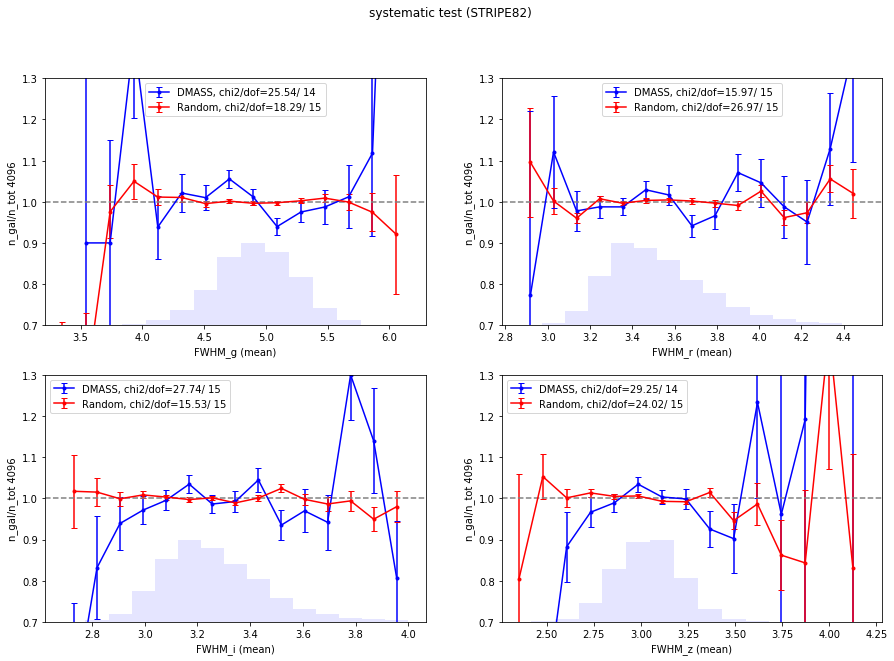

In [204]:

from systematics_module.contCorrection import doVisualization_ngal

nside = 4096
kind='STRIPE82'
suffix='1'

inputdir = '../data_txt/systematics/test/'
figoutdir = '../data_txt/systematics/test/figure/'

for p in ['FWHM']: 
    doVisualization_ngal(property = p, nside = nside, kind = kind, suffix=suffix, inputdir=inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/test/figure/systematic_FWHM_SPT_1.png


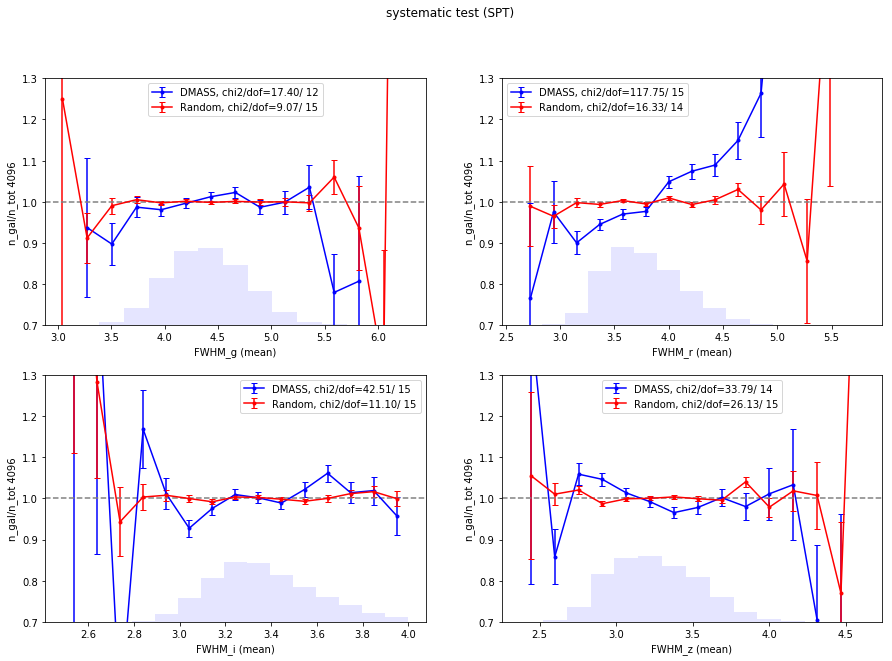

In [160]:

from systematics_module.contCorrection import doVisualization_ngal

nside = 4096
kind='SPT'
suffix='1'

inputdir = '../data_txt/systematics/test/'
figoutdir = '../data_txt/systematics/test/figure/'

for p in ['FWHM']: 
    doVisualization_ngal(property = p, nside = nside, kind = kind, suffix=suffix, inputdir=inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/no_mask/test/systematic_FWHM_SPT_1.png


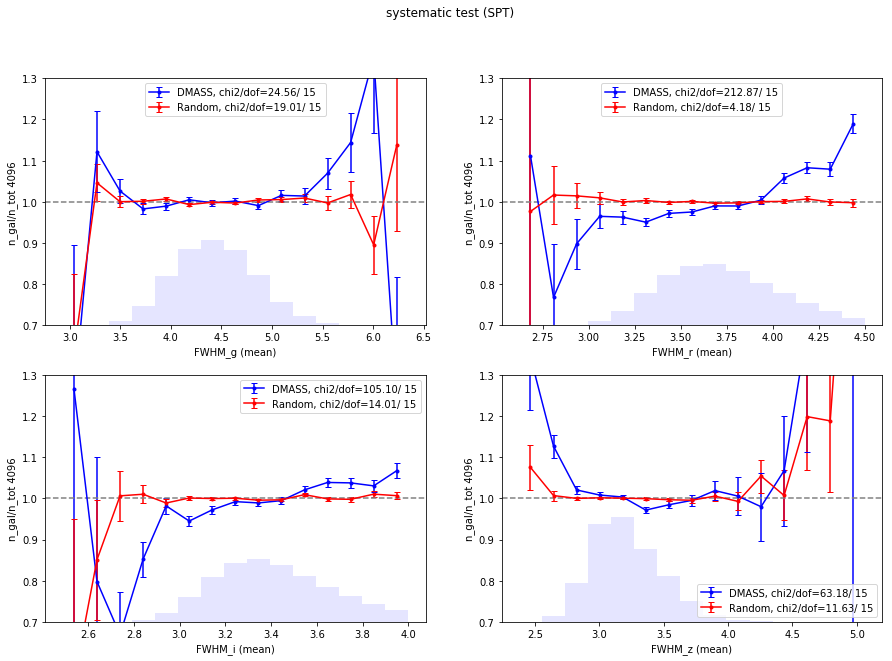

In [1484]:

from systematics_module.contCorrection import doVisualization_ngal

nside = 4096
kind='SPT'
suffix='1'

inputdir = '../data_txt/systematics/test/'
figoutdir = '../data_txt/systematics/no_mask/test/'

for p in ['FWHM']: 
    doVisualization_ngal(property = p, nside = nside, kind = kind, suffix=suffix, inputdir=inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/no_mask/figure/systematic_FWHM_SPT_1.png


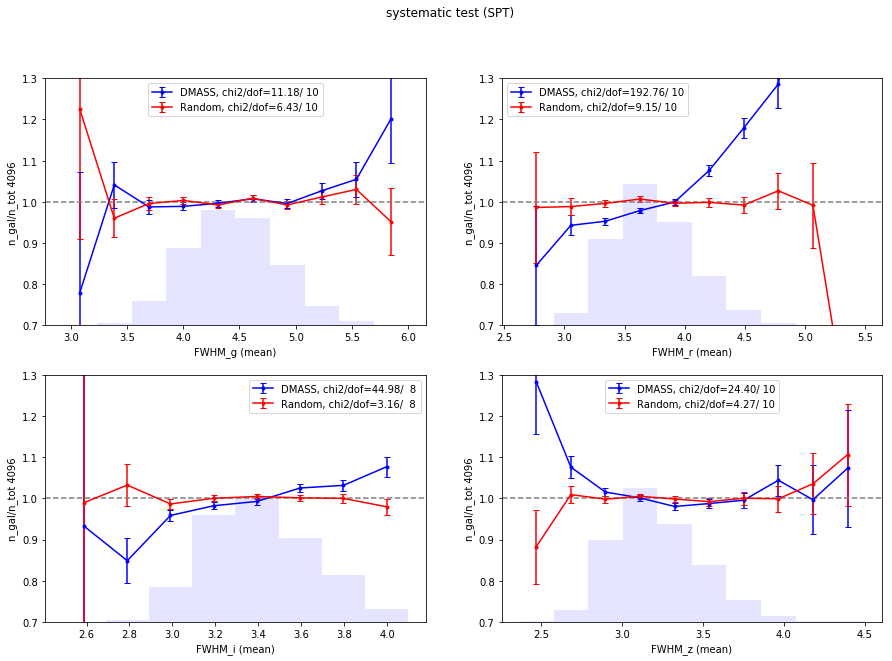

In [1148]:

from systematics_module.contCorrection import doVisualization_ngal

nside = 4096
kind='SPT'
suffix='1'

inputdir = '../data_txt/systematics/no_mask/'
figoutdir = '../data_txt/systematics/no_mask/figure/'

for p in ['FWHM']: 
    doVisualization_ngal(property = p, nside = nside, kind = kind, suffix=suffix, inputdir=inputdir, outdir=figoutdir)

 saving fig to  ../data_txt/systematics/exp_i_mask/figure/systematic_DEPTH_SPT_1.png
saving fig to  ../data_txt/systematics/exp_i_mask/figure/systematic_EXPTIME_SPT_1.png
saving fig to  ../data_txt/systematics/exp_i_mask/figure/systematic_AIRMASS_SPT_1.png
saving fig to  ../data_txt/systematics/exp_i_mask/figure/systematic_SKYBRITE_SPT_1.png
saving fig to  ../data_txt/systematics/exp_i_mask/figure/systematic_FWHM_SPT_1.png


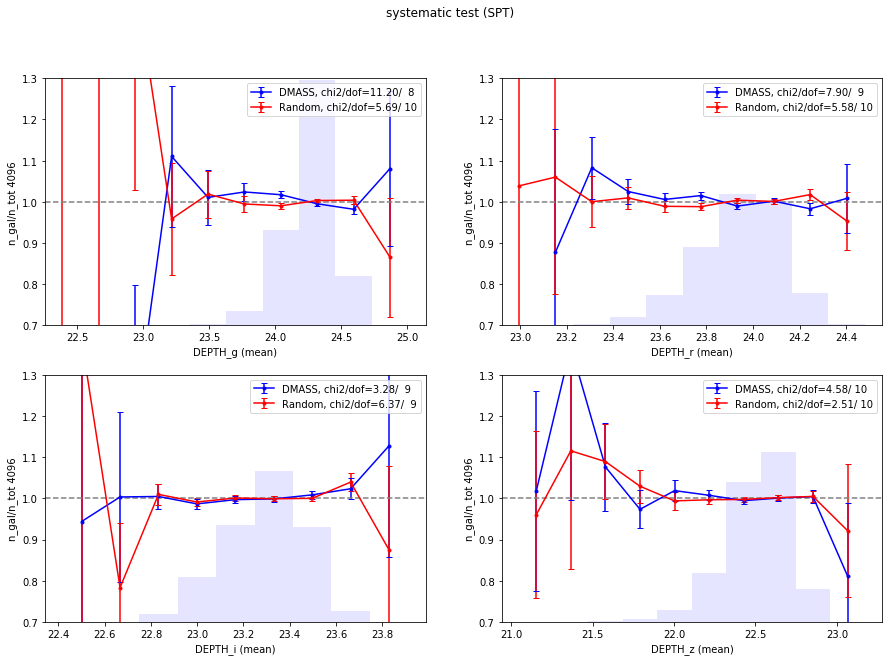

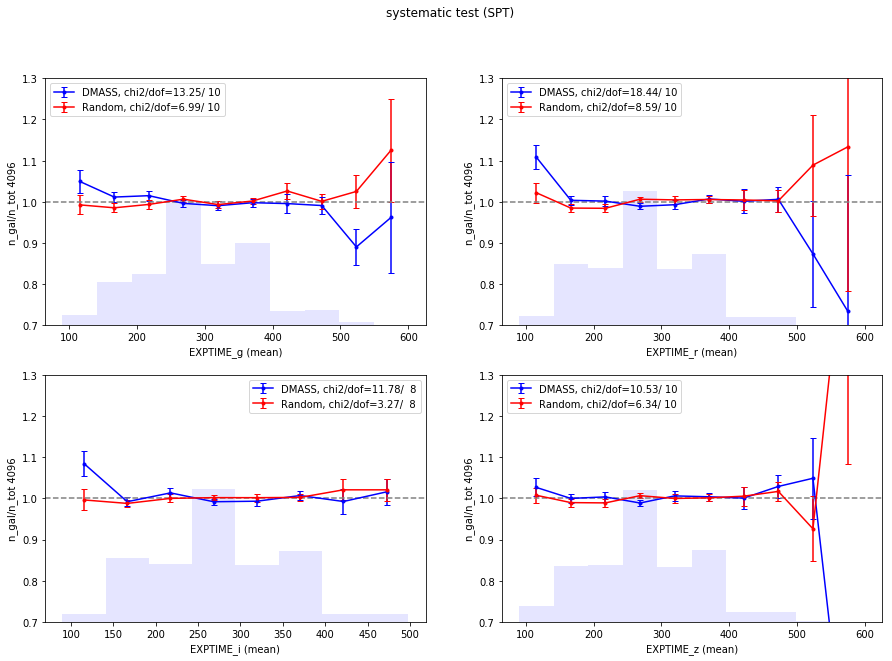

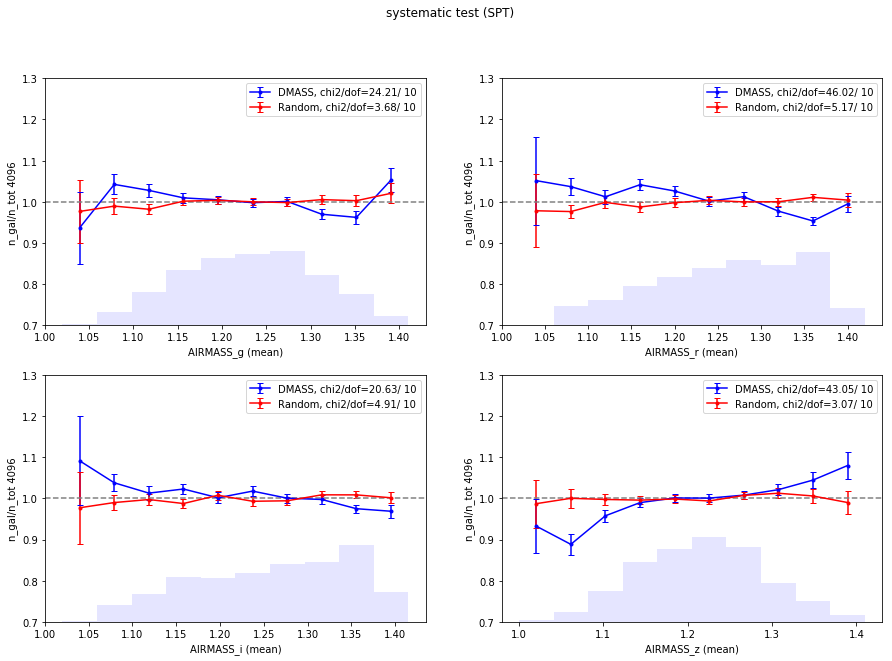

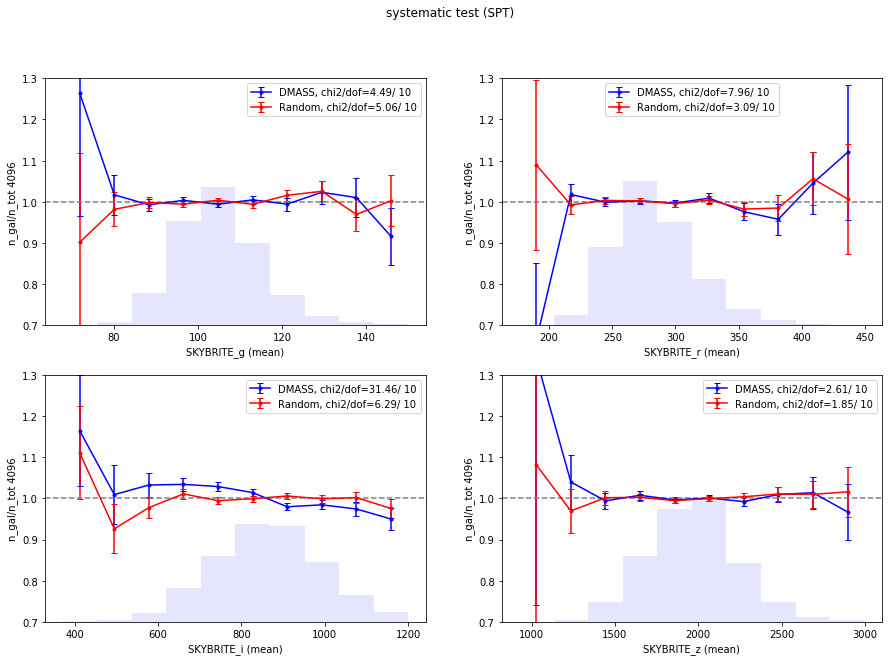

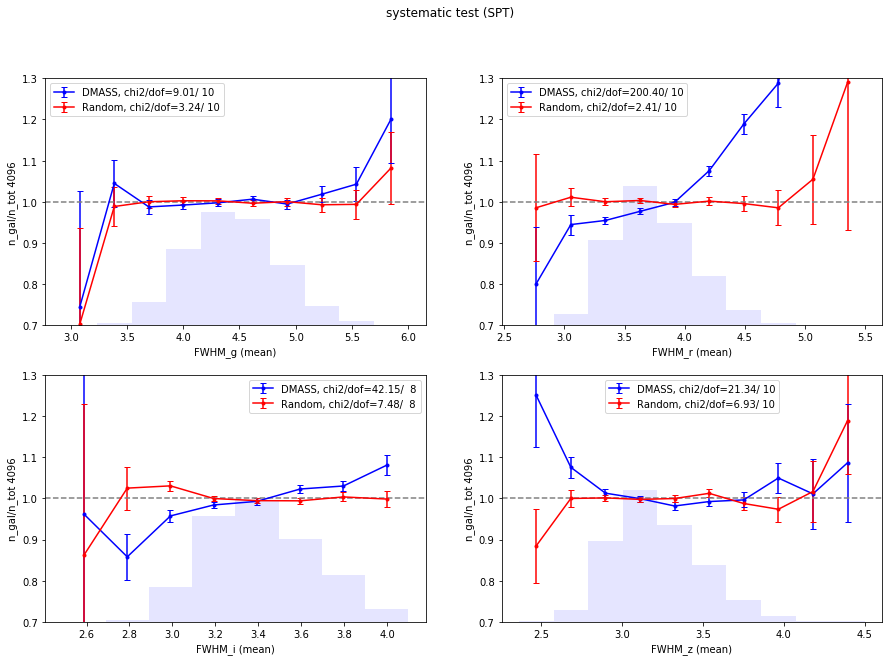

In [130]:

from systematics_module.contCorrection import doVisualization_ngal

nside = 4096
kind='SPT'
suffix='1'

inputdir = '../data_txt/systematics/exp_i_mask/'
figoutdir = '../data_txt/systematics/exp_i_mask/figure/'

for p in properties: 
    doVisualization_ngal(property = p, nside = nside, kind = kind, suffix=suffix, inputdir=inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_DEPTH_SPT_1.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_EXPTIME_SPT_1.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_AIRMASS_SPT_1.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_SKYBRITE_SPT_1.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_FWHM_SPT_1.png


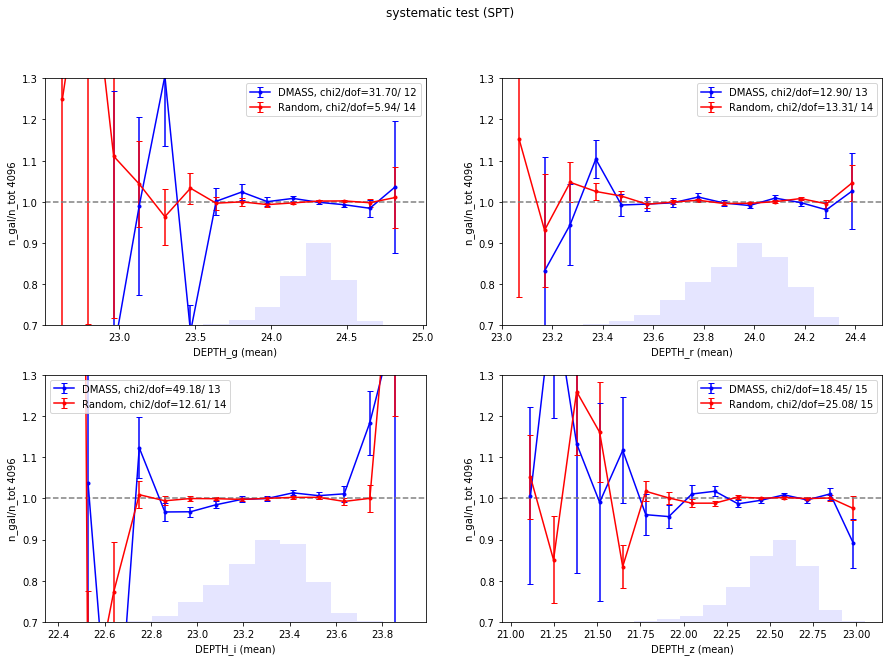

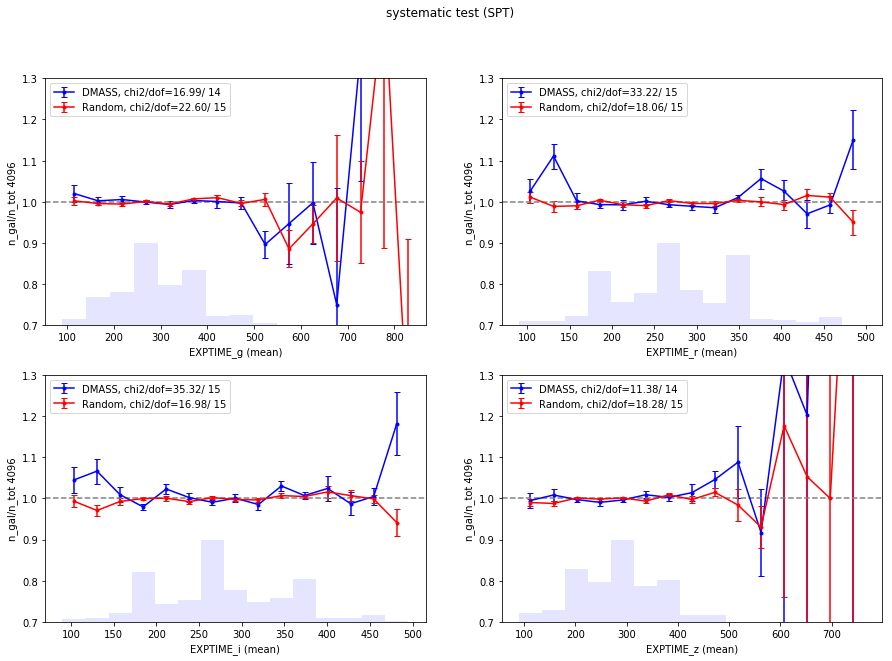

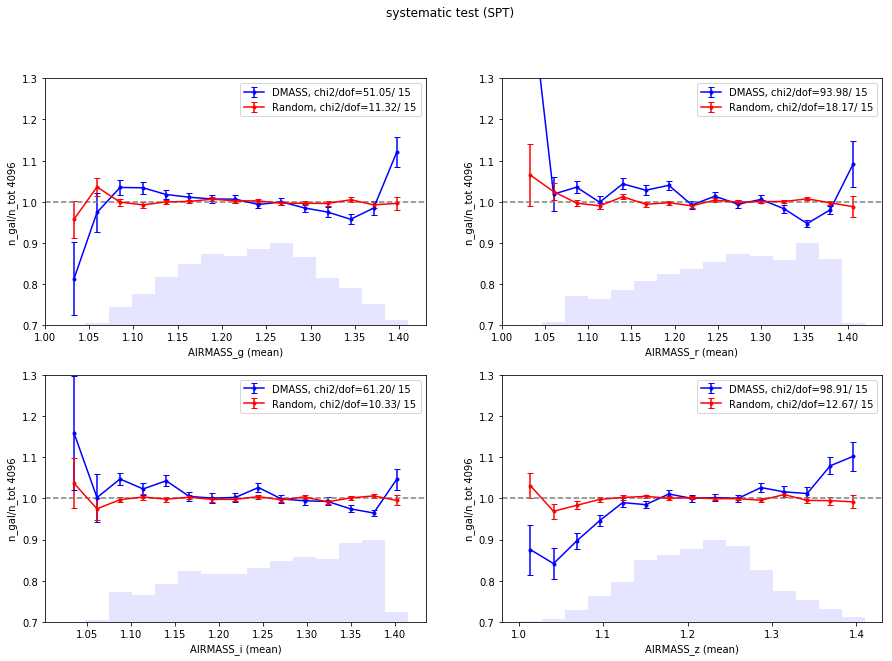

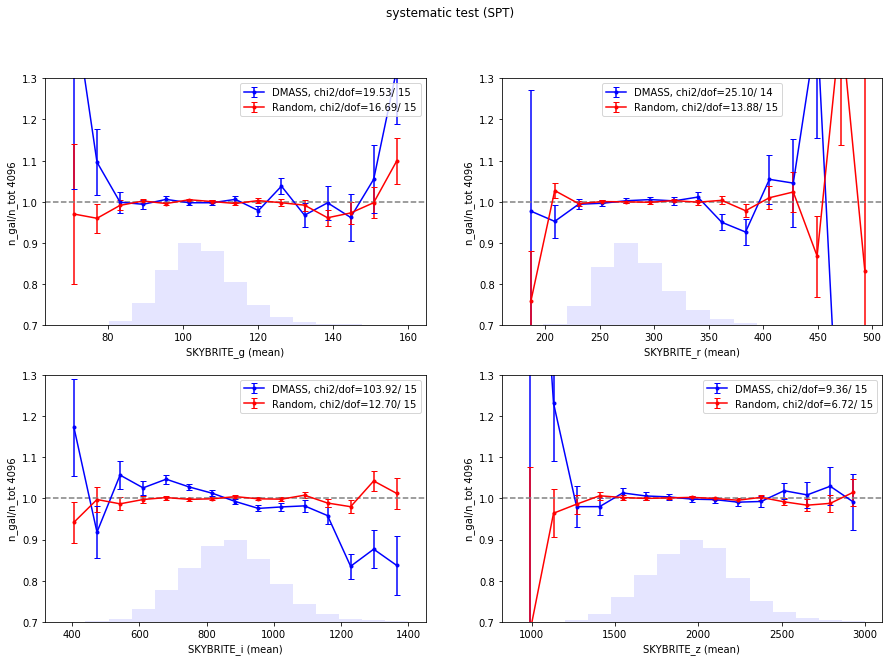

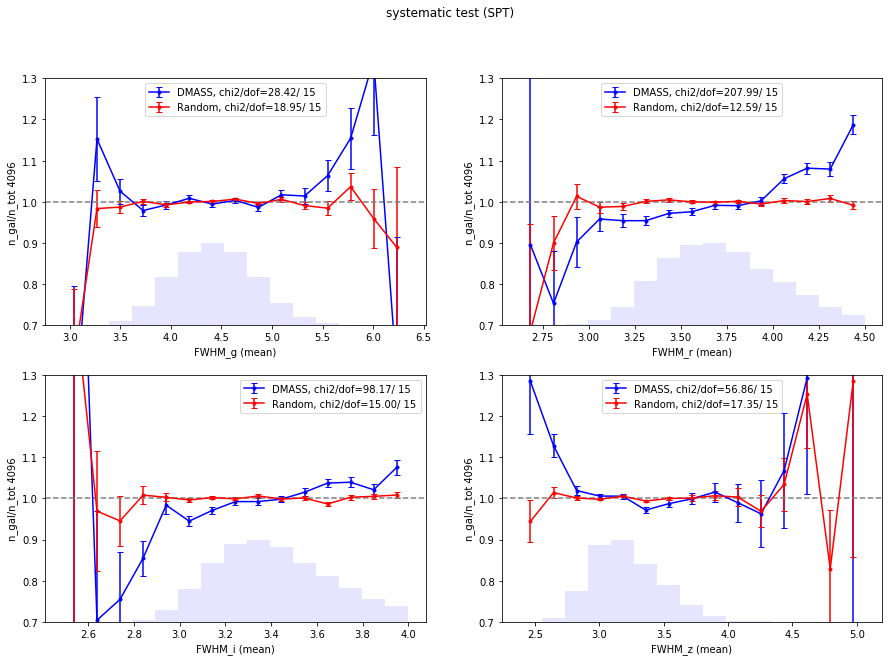

In [234]:

from systematics_module.contCorrection import doVisualization_ngal

nside = 4096
kind='SPT'
suffix='1'

inputdir = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
figoutdir ='../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/'

for p in properties: 
    doVisualization_ngal(property = p, nside = nside, kind = kind, suffix=suffix, inputdir=inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/figure/systematic_DEPTH_STRIPE82_1.png
saving fig to  ../data_txt/systematics/figure/systematic_EXPTIME_STRIPE82_1.png
saving fig to  ../data_txt/systematics/figure/systematic_AIRMASS_STRIPE82_1.png
saving fig to  ../data_txt/systematics/figure/systematic_SKYBRITE_STRIPE82_1.png
saving fig to  ../data_txt/systematics/figure/systematic_SKYSIGMA_STRIPE82_1.png
saving fig to  ../data_txt/systematics/figure/systematic_FWHM_STRIPE82_1.png
saving fig to  ../data_txt/systematics/figure/systematic_NSTARS_STRIPE82_1.png


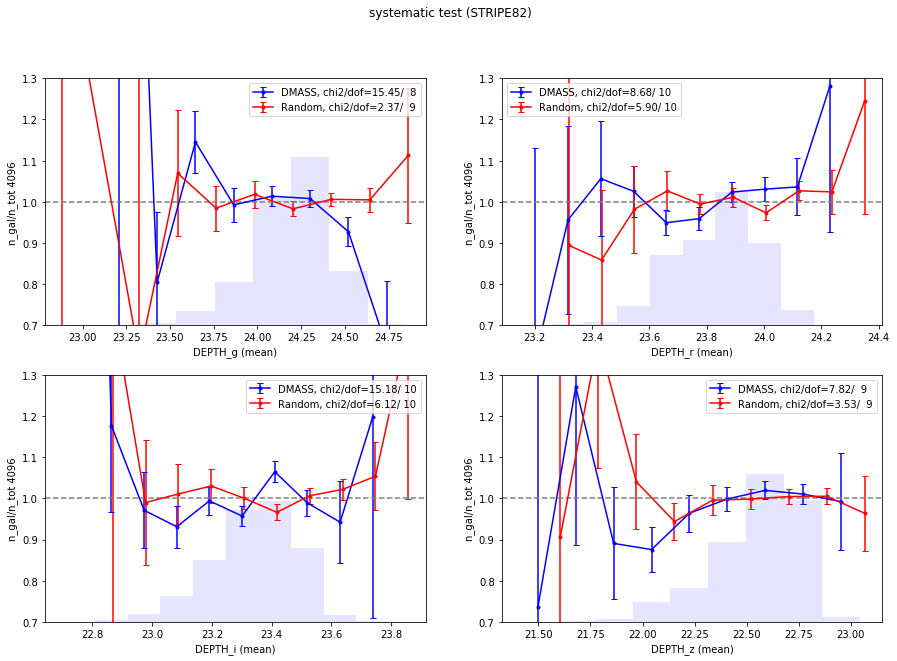

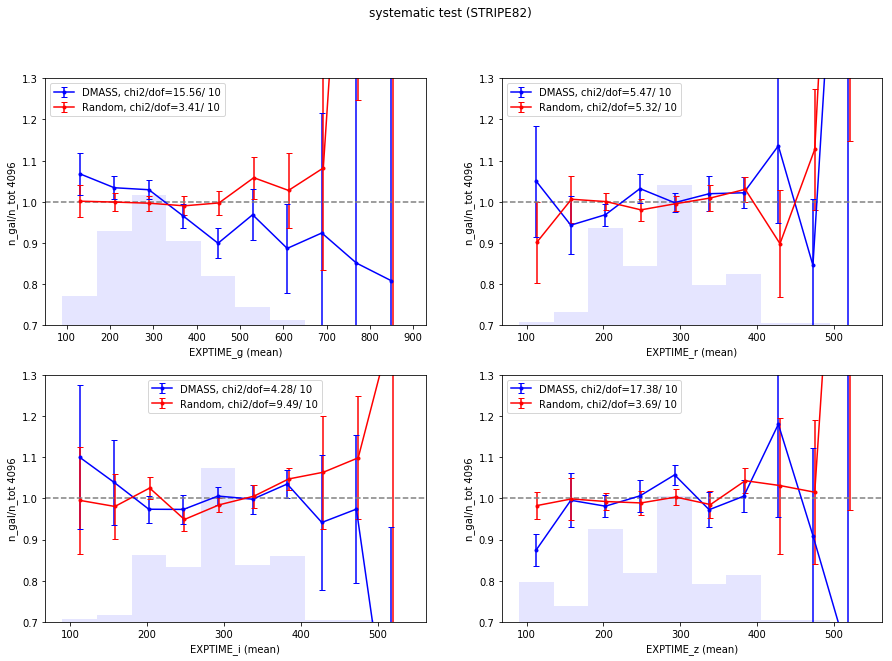

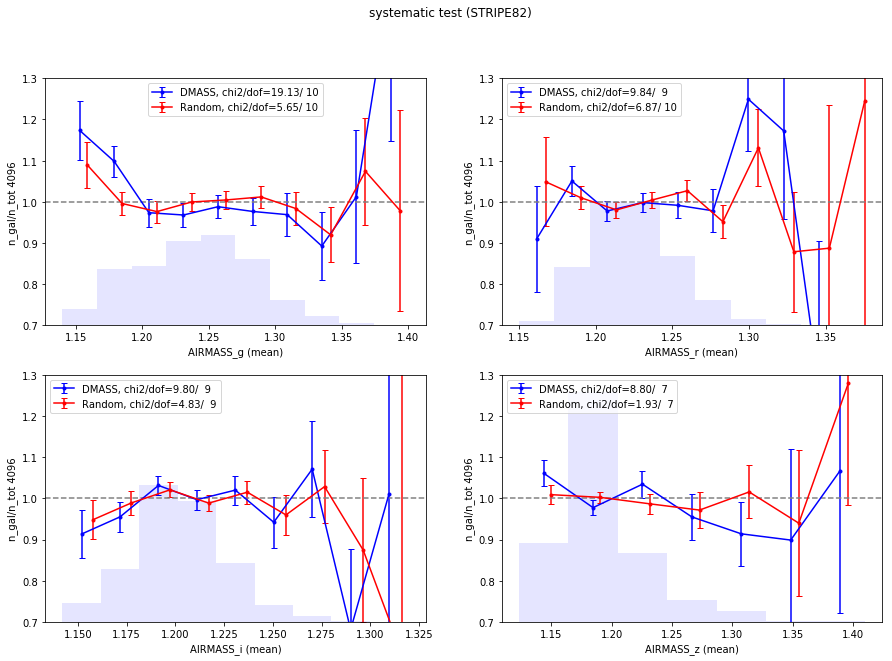

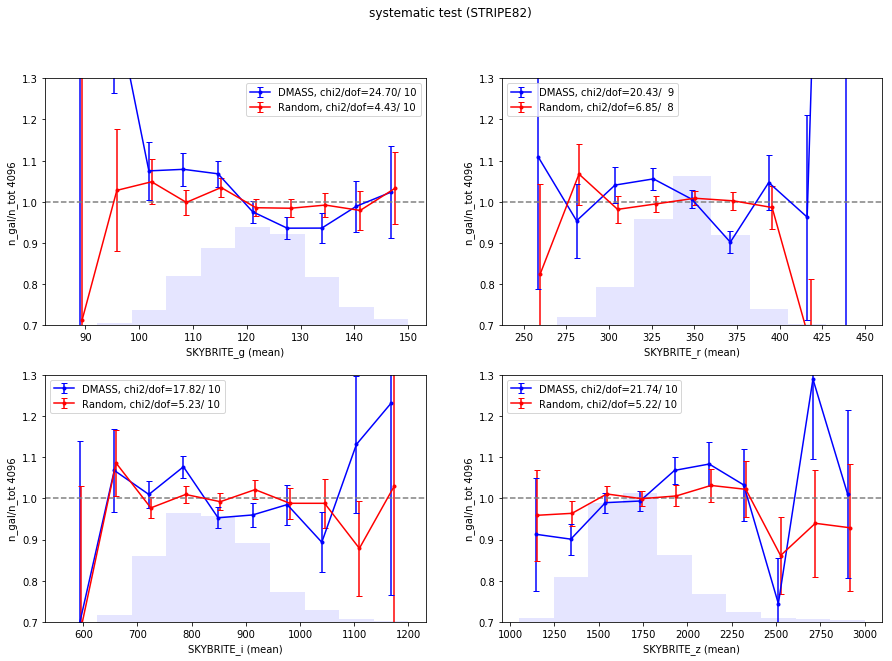

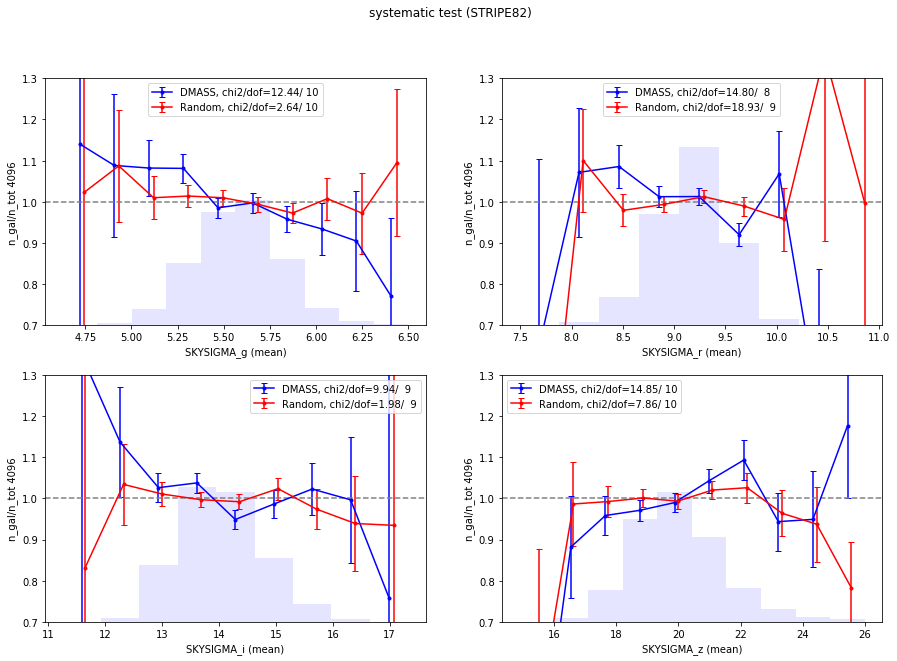

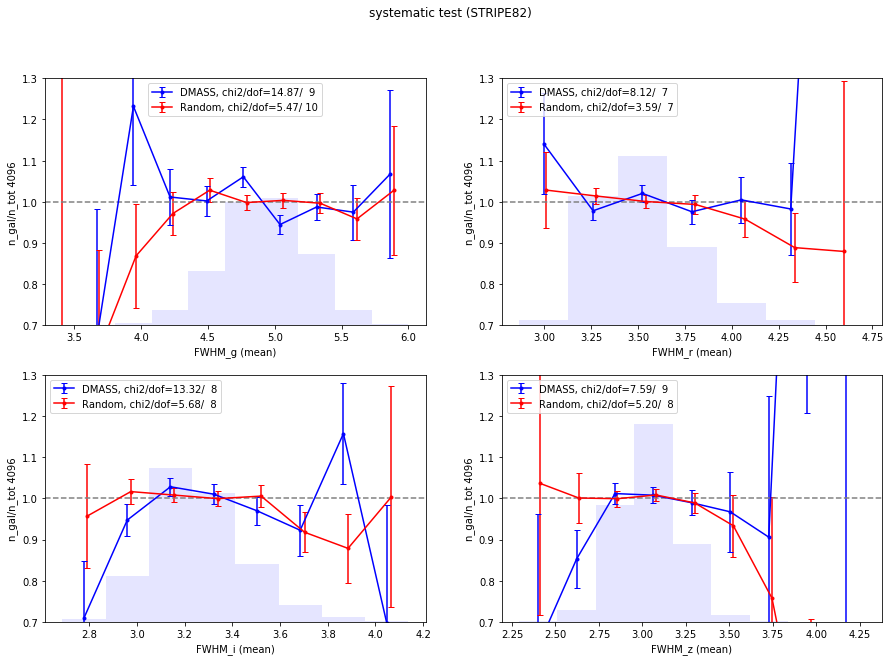

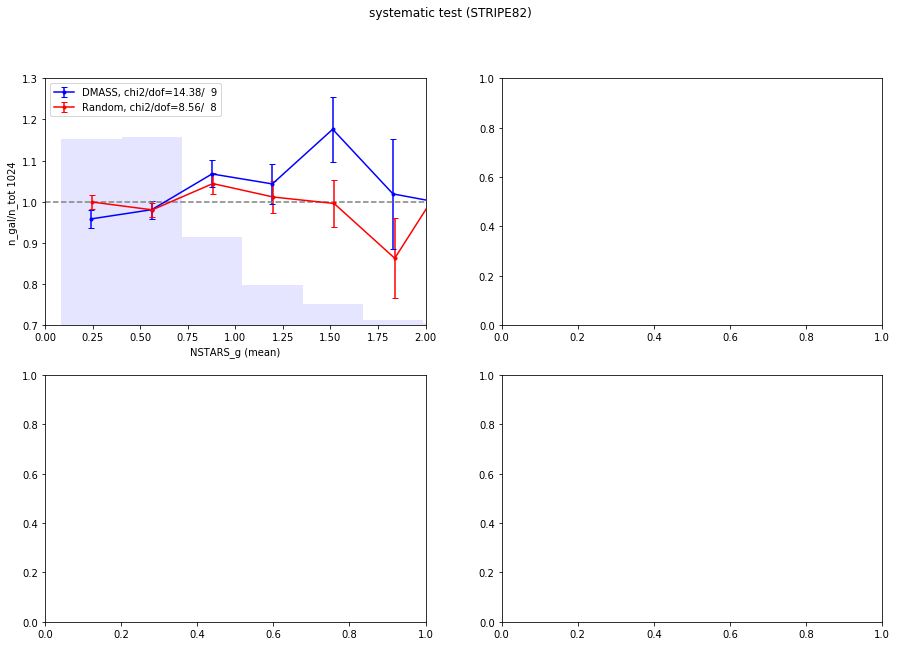

In [230]:

from systematics_module.contCorrection import doVisualization_ngal

figoutdir = '../data_txt/systematics/figure/'
for p in properties: 
    doVisualization_ngal(property = p, nside = nside, kind = 'STRIPE82', suffix=suffix, outdir=figoutdir)

### Fitting seeing_i

In [11]:
#data_mask = Cbins < 5.0
#def linear_fitting( filename )
def fitting_linear( x_predict, xdata, ydata, yerr):
    import scipy
    powerlaw = lambda x, amp, index: amp * (x**index)
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    logyerr = yerr / ydata

    # define our (line) fitting function
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

    pinit = [1.0, -1.0]
    out = scipy.optimize.leastsq(errfunc, pinit,
                           args=(logx, logy, logyerr), full_output=1)

    pfinal = out[0]
    covar = out[1]

    #print pfinal
    #print covar


    index = pfinal[1]
    amp = 10.0**pfinal[0]
    
    #print index, amp
    
    indexErr = np.sqrt( covar[0][0] )
    ampErr = np.sqrt( covar[1][1] ) * amp
    
    y_predict = powerlaw(x_predict, amp, index)
    return x_predict, y_predict

In [12]:
#data_mask = Cbins < 5.0
#def linear_fitting( filename )
def fitting_linear( x_predict, xdata, ydata, yerr):
    import scipy
    #powerlaw = lambda x, amp, index: amp * (x**index)
    #logx = np.log10(xdata)
    #logy = np.log10(ydata)
    #logyerr = yerr / ydata

    # define our (line) fitting function
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

    pinit = [1.0, -1.0]
    out = scipy.optimize.leastsq(errfunc, pinit,
                           args=(xdata, ydata, yerr), full_output=1)

    pfinal = out[0]
    covar = out[1]

    #print pfinal
    #print covar


    #index = pfinal[1]
    #amp = 10.0**pfinal[0]
    
    #print index, amp
    
    #indexErr = np.sqrt( covar[0][0] )
    #ampErr = np.sqrt( covar[1][1] ) * amp
    
    #y_predict = powerlaw(x_predict, amp, index)
    y_predict = fitfunc(pfinal, x_predict)
    return x_predict, y_predict

In [13]:
#data_mask = Cbins < 5.0
#def linear_fitting( filename )
def fitting_errftn( x_predict, xdata, ydata, yerr):
    import scipy
    #powerlaw = lambda x, amp, index: amp * (x**index)
    #logx = np.log10(xdata)
    #logy = np.log10(ydata)
    #logyerr = yerr / ydata

    # define our (line) fitting function
    #fitfunc = lambda p, x: p[0] + p[1] * x
    fitfunc = lambda p, x : p[0] * ( 1. - scipy.special.erf( (x-p[1])*1./p[2]  ))
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

    #pinit = [1.0, -1.0]
    
    xmid = (xdata.max() - xdata.min()) /2.
    pinit = [1, xmid, xmid ]
    out = scipy.optimize.leastsq(errfunc, pinit,
                           args=(xdata, ydata, yerr), full_output=1)

    pfinal = out[0]
    covar = out[1]
    
    y_predict = fitfunc( pfinal, x_predict )
    return x_predict, y_predict

In [14]:
#data_mask = Cbins < 5.0
#def linear_fitting( filename )
def fitting_errftn2( x_predict, xdata, ydata, yerr):
    import scipy
    #powerlaw = lambda x, amp, index: amp * (x**index)
    #logx = np.log10(xdata)
    #logy = np.log10(ydata)
    #logyerr = yerr / ydata

    # define our (line) fitting function
    #fitfunc = lambda p, x: p[0] + p[1] * x
    fitfunc = lambda p, x : p[0] * ( 1. + scipy.special.erf( (x-p[1])*1./p[2]  ))
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

    #pinit = [1.0, -1.0]
    pinit = [1.0, 1.0, 1.0]
    out = scipy.optimize.leastsq(errfunc, pinit,
                           args=(xdata, ydata, yerr), full_output=1)

    pfinal = out[0]
    covar = out[1]
    
    y_predict = fitfunc( pfinal, x_predict )
    return x_predict, y_predict

In [15]:
xdata = np.linspace(10, 500.0, 500)
xdatasqr = np.sqrt(xdata)
yclean = lambda a,b,x : a * x + 10**b
noise = np.random.normal(0, 10, xdata.shape)
ydata = yclean(0.1, 2, xdatasqr) + noise

In [1352]:
import scipy

In [1480]:
xdata = np.linspace(400.0, 1400.0, 500)
yclean =  lambda p, x : p[0] * (scipy.special.erf( (x-p[1])*1./p[2]  ))
#yclean = lambda p,x : p[0] + x * p[1] #p[0] * x + 10**p[2]
noise = np.random.normal(0, 0.1, xdata.shape)
ydata = yclean((-10, 10, -100), np.sqrt(xdata) )# + noise

print xdata.shape, ydata.shape

(500,) (500,)


In [1481]:
x_predict, y_predict = fitting_errftn2( np.sqrt(xdata), np.sqrt(xdata), ydata, noise )

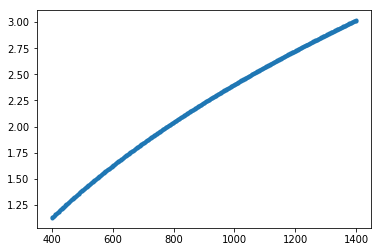

In [1482]:
fig, ax = plt.subplots()
ax.plot(xdata, ydata, '.')
#ax.plot(xdatasqr, ydata - noise, 'k-')
#ax.plot(xdata, y_predict )

#logx = np.log10(xdata)
#logy =  fitfunc( (100,10), logx )
#powerlaw = lambda x, amp, index: amp * (x**index)

#ax.plot( logx, logy )

In [16]:
# call file

def fitting_SP( property = None, filter=None, kind = None, suffix='', plot=False, function = None,
                path = '../data_txt/systematics/'):

   
    import scipy
    
    for p in property : 
        if plot : 
            fig, ax = plt.subplots(2,2,figsize = (15,10))
            ax = ax.ravel()
            i = 0
        for f in filter : 
            filename = path+'systematic_'+p+'_'+f+'_'+kind+'_'+suffix+'.txt'
            #print filename
            data = np.loadtxt(filename)
            bins, Cdensity, Cerr, Cf_area, Rdensity, Rerr, Rf_area = [data[:,j] for j in range(data[0].size)]
            zeromaskC, zeromaskR = ( Cdensity != 0.0 ), (Rdensity != 0.0 )
            Cbins, Cdensity, Cerr = bins[zeromaskC], Cdensity[zeromaskC], Cerr[zeromaskC]
            Rbins, Rdensity, Rerr = bins[zeromaskR], Rdensity[zeromaskR], Rerr[zeromaskR]                                                  
            
            C_bin_predict = np.zeros(bins.size)
            R_bin_predict = np.zeros(bins.size)
            #predict[~zeromaskC] = np.nan

            _, R_predict = fitting_linear( bins, Rbins, Rdensity, Rerr)
            if function == 'linear':
                _, C_predict = fitting_linear( bins, Cbins, Cdensity, Cerr)
                #_, R_predict = fitting_linear( bins, Rbins, Rdensity, Rerr)
                
            elif function == 'sqrt' : 
                #Cbins = np.sqrt(Cbins)
                #Rbins = np.sqrt(Rbins)
                _, C_predict = fitting_linear( np.sqrt(bins), np.sqrt(Cbins), Cdensity, Cerr)
                #_, R_predict = fitting_linear( np.sqrt(bins), np.sqrt(Rbins), Rdensity, Rerr) 
                
            elif function == 'errftn' : 
                _, C_predict = fitting_errftn( bins, Cbins, Cdensity, Cerr)
                
                #_, R_predict = fitting_errftn( bins, Rbins, Rdensity, Rerr)                 
                
            else : print 'Please enter the kind of fitting function'
                
            Cchi2_model = np.sum((Cdensity - C_predict[zeromaskC])**2 *1./Cerr**2)
            Rchi2_model = np.sum((Rdensity - R_predict[zeromaskR])**2 *1./Rerr**2)
 
            Cchi2_null = np.sum((Cdensity - 1.0)**2 *1./Cerr**2)
            Rchi2_null = np.sum((Rdensity - 1.0)**2 *1./Rerr**2)
        
            Del_Cchi2 = Cchi2_null - Cchi2_model 
            Del_Rchi2 = Rchi2_null - Rchi2_model
            
            print 'chi2_null = ', Cchi2_null
            print 'chi2_mod. = ', Cchi2_model
            print 'Delta chi2 (sample) =', Cchi2_null - Cchi2_model 
            
            
            #print 'Delta chi2 (sample) =', Cchi2_null - Cchi2_model 
            #print 'Delta chi2 (random) =', Rchi2_null - Rchi2_model
            
            #If chisqr is larger than 68% of the mocks, label it as Delta chisqr(68).
            Delta_chi2_68 = 0.68 * Del_Rchi2
            significance = Del_Cchi2/Delta_chi2_68
            print 'Delta_chi2_68 = ', Delta_chi2_68
            print 'significance = ', significance
            
            #C_bin_predict[zeromaskC] = C_predict
            #C_bin_predict[~zeromaskC] = np.nan
            #R_bin_predict[zeromaskR] = R_predict
            #R_bin_predict[~zeromaskR] = np.nan

            
            DAT = np.column_stack((bins, C_predict, R_predict))
            header = 'Delta chi2 (sample) = '+ str(Del_Cchi2)+ '\nDelta chi2 (random) = '+str(Del_Rchi2) +\
            '\nDelta_chi2_68 = '+ str(Delta_chi2_68) + '\nsignificance = '+str(significance)+\
            '\nbins, Sample, Random'
            
            np.savetxt(filename+'.model', DAT, header =header)
            print 'output save to ', filename+'.model\n'
            
            if plot : 
                ax[i].errorbar(Cbins, Cdensity, yerr=Cerr, fmt='b-', label='dmass' + ' $\Delta \chi^2={:0.2f}$'.format(Del_Cchi2))
                ax[i].errorbar(Rbins, Rdensity, yerr=Rerr, fmt='r-', label='random')
                ax[i].plot(bins, C_predict, 'b--', alpha=1.0)
                #ax[i].plot(Rbins*1.005, R_predict, 'r-', alpha = 0.3)
                ax[i].plot(bins*1.005, R_predict, 'r--', alpha = 1.0)
                ax[i].axhline(y=1.0, color='grey', ls = '--')
                ax[i].set_xlabel(p+'_'+f)
                ax[i].set_ylabel('galaxy num density')
                ax[i].set_ylim(0.7, 1.3)
                ax[i].legend(loc=1)
                i += 1

#Cdensity, Cbins, Cerr = Cdensity[zeromaskC], bins[zeromaskC], Cerr[zeromaskC]
#C_jkerr = C_jkerr[zeromaskC]
#Rdensity, Rbins, Rerr = Rdensity[zeromaskR],bins[zeromaskR], Rerr[zeromaskR]
#B_jkerr = B_jkerr[zeromaskB]

In [17]:
# call file

def calculate_weight( property = None, filter=None, kind = None, suffix='', plot=False, function = None,
                path = '../data_txt/systematics/', catalog = None, sysMap= None, 
                weight=False, raTag ='RA', decTag='DEC', nside=4096):

   
    import scipy
    
    for p in property : 
        if plot : 
            fig, ax = plt.subplots(2,2,figsize = (15,10))
            ax = ax.ravel()
            i = 0
        for f in filter : 
            filename = path+'systematic_'+p+'_'+f+'_'+kind+'_'+suffix+'.txt'
            #print filename
            data = np.loadtxt(filename)
            bins, Cdensity, Cerr, Cf_area, Rdensity, Rerr, Rf_area = [data[:,j] for j in range(data[0].size)]
            zeromaskC, zeromaskR = ( Cdensity != 0.0 ), (Rdensity != 0.0 )
            Cbins, Cdensity, Cerr = bins[zeromaskC], Cdensity[zeromaskC], Cerr[zeromaskC]
            Rbins, Rdensity, Rerr = bins[zeromaskR], Rdensity[zeromaskR], Rerr[zeromaskR]                                                  
            
            C_bin_predict = np.zeros(bins.size)
            R_bin_predict = np.zeros(bins.size)
            #predict[~zeromaskC] = np.nan

            if function == 'linear':
                _, C_predict = fitting_linear( bins, Cbins, Cdensity, Cerr)
                _, R_predict = fitting_linear( bins, Rbins, Rdensity, Rerr)
                
            elif function == 'sqrt' : 
                #Cbins = np.sqrt(Cbins)
                #Rbins = np.sqrt(Rbins)
                _, C_predict = fitting_linear( np.sqrt(bins), np.sqrt(Cbins), Cdensity, Cerr)
                _, R_predict = fitting_linear( np.sqrt(bins), np.sqrt(Rbins), Rdensity, Rerr) 
                
            elif function == 'errftn' : 
                _, C_predict = fitting_errftn( bins, Cbins, Cdensity, Cerr)
                _, R_predict = fitting_errftn( bins, Rbins, Rdensity, Rerr)                 
                
            else : print 'Please enter the kind of fitting function'
                
            Cchi2_model = np.sum((Cdensity - C_predict[zeromaskC])**2 *1./Cerr**2)
            Rchi2_model = np.sum((Rdensity - R_predict[zeromaskR])**2 *1./Rerr**2)
 
            Cchi2_null = np.sum((Cdensity - 1.0)**2 *1./Cerr**2)
            Rchi2_null = np.sum((Rdensity - 1.0)**2 *1./Rerr**2)
        
            Del_Cchi2 = Cchi2_null - Cchi2_model 
            Del_Rchi2 = Rchi2_null - Rchi2_model
            print 'chi2_null = ', Cchi2_null
            print 'chi2_mod. = ', Cchi2_model
            print 'Delta chi2 (sample) =', Cchi2_null - Cchi2_model 
            #print 'Delta chi2 (random) =', Rchi2_null - Rchi2_model
            
            #If chisqr is larger than 68% of the mocks, label it as Delta chisqr(68).
            Delta_chi2_68 = 0.68 * Del_Rchi2
            significance = Del_Cchi2/Delta_chi2_68
            print 'Delta_chi2_68 = ', Delta_chi2_68
            print 'significance = ', significance
            
            DAT = np.column_stack((bins, C_predict, R_predict))
            header = 'Delta chi2 (sample) = '+ str(Del_Cchi2)+ '\nDelta chi2 (random) = '+str(Del_Rchi2) +\
            '\nDelta_chi2_68 = '+ str(Delta_chi2_68) + '\nsignificance = '+str(significance)+\
            '\nbins, Sample, Random'
            
            np.savetxt(filename+'.model', DAT, header =header)
            print 'output save to ', filename+'.model\n'
            
            if plot : 
                ax[i].errorbar(Cbins, Cdensity, yerr=Cerr, fmt='b-', label='dmass')
                ax[i].errorbar(Rbins, Rdensity, yerr=Rerr, fmt='r-', label='random')
                ax[i].plot(bins, C_predict, 'b--', alpha=1.0)
                #ax[i].plot(Rbins*1.005, R_predict, 'r-', alpha = 0.3)
                ax[i].plot(bins*1.005, R_predict, 'r--', alpha = 1.0)
                ax[i].axhline(y=1.0, color='grey', ls = '--')
                ax[i].set_xlabel(p+'_'+f)
                ax[i].set_ylabel('galaxy num density')
                ax[i].set_ylim(0.7, 1.3)
                ax[i].legend(loc=1)
                i += 1

    
    #wg_dic = {}
    if weight : 
        for p in property : 
            for f in filter : 
            
                mapname = 'sys_'+p+'_'+f+'_'+kind #+'_masked'
                catHpInd = hpRaDecToHEALPixel(catalog[raTag], catalog[decTag], nside=nside, nest= False)
                #signal = sysMap[mapname]['SIGNAL'][catHpInd]

                min = np.min(sysMap[mapname]['SIGNAL'])
                max = np.max(sysMap[mapname]['SIGNAL'])
                bin_num = 100
                bin_center, binned_cat, keeps = divide_bins( sysMap[mapname], Tag = 'SIGNAL', \
                                                            min = min, max = max, bin_num = bin_num )


                if function == 'linear':
                    _, C_predict = fitting_linear( bin_center, Cbins, Cdensity, Cerr)

                elif function == 'sqrt' : 
                    _, C_predict = fitting_linear( np.sqrt(bin_center), np.sqrt(Cbins), Cdensity, Cerr)

                elif function == 'errftn' : 
                    _, C_predict = fitting_errftn( bin_center, Cbins, Cdensity, Cerr)                

                else : 
                    print 'Please enter the kind of fitting function'
                    return 0


                wg = np.zeros( catalog.size, dtype=float)
                for i, sysMap_i in enumerate(binned_cat):
                    HpIdxInSys_mask = np.in1d(catHpInd, sysMap_i['PIXEL'])
                    wg[HpIdxInSys_mask] = 1./C_predict[i]
                
                
        return wg
#Cdensity, Cbins, Cerr = Cdensity[zeromaskC], bins[zeromaskC], Cerr[zeromaskC]
#C_jkerr = C_jkerr[zeromaskC]
#Rdensity, Rbins, Rerr = Rdensity[zeromaskR],bins[zeromaskR], Rerr[zeromaskR]
#B_jkerr = B_jkerr[zeromaskB]

chi2_null =  31.70247551490524
chi2_mod. =  30.8064853304622
Delta chi2 (sample) = 0.8959901844430433
Delta_chi2_68 =  1.1898815363414654
significance =  0.7530078895063359
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_1.txt.model

chi2_null =  12.89838013245944
chi2_mod. =  12.622086745961132
Delta chi2 (sample) = 0.2762933864983079
Delta_chi2_68 =  0.019050353901208652
significance =  14.503320407122645
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_1.txt.model

chi2_null =  49.1778454654072
chi2_mod. =  32.43279562852386
Delta chi2 (sample) = 16.74504983688334
Delta_chi2_68 =  0.4868662603300577
significance =  34.39353103977977
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_1.txt.model

chi2_null =  18.450519277594832
chi2_mod. =  18.258154441511493
Delta chi2 (sample) = 0.19236483608333899
Delta_chi2_68 =  0.798571381

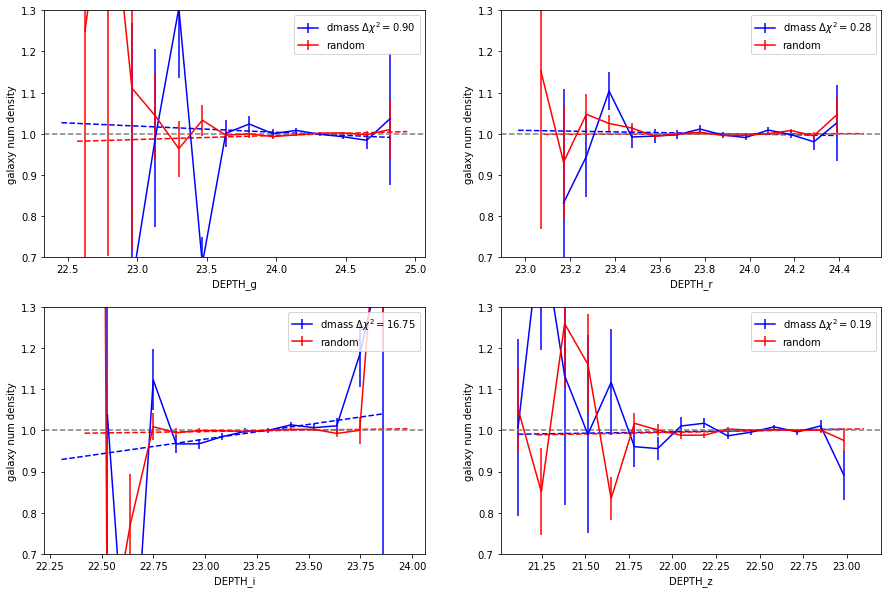

In [256]:
path = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
fitting_SP( property = ['DEPTH'], filter=['g', 'r', 'i', 'z'], kind = 'SPT', suffix='1', plot=True, path=path
          , function = 'linear')

chi2_null =  16.9874935979268
chi2_mod. =  14.879959516608423
Delta chi2 (sample) = 2.107534081318377
Delta_chi2_68 =  1.164633935309973
significance =  1.809610743273977
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_g_SPT_1.txt.model

chi2_null =  33.219645653923685
chi2_mod. =  33.112922893614204
Delta chi2 (sample) = 0.10672276030948069
Delta_chi2_68 =  0.5095542768578624
significance =  0.2094433609066743
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_r_SPT_1.txt.model

chi2_null =  35.32469974782166
chi2_mod. =  33.72851188819982
Delta chi2 (sample) = 1.5961878596218426
Delta_chi2_68 =  2.099313697229928
significance =  0.7603379436470278
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_i_SPT_1.txt.model

chi2_null =  11.384718822355918
chi2_mod. =  9.054016600786744
Delta chi2 (sample) = 2.330702221569174
Delta_chi2_68 =  2.795023

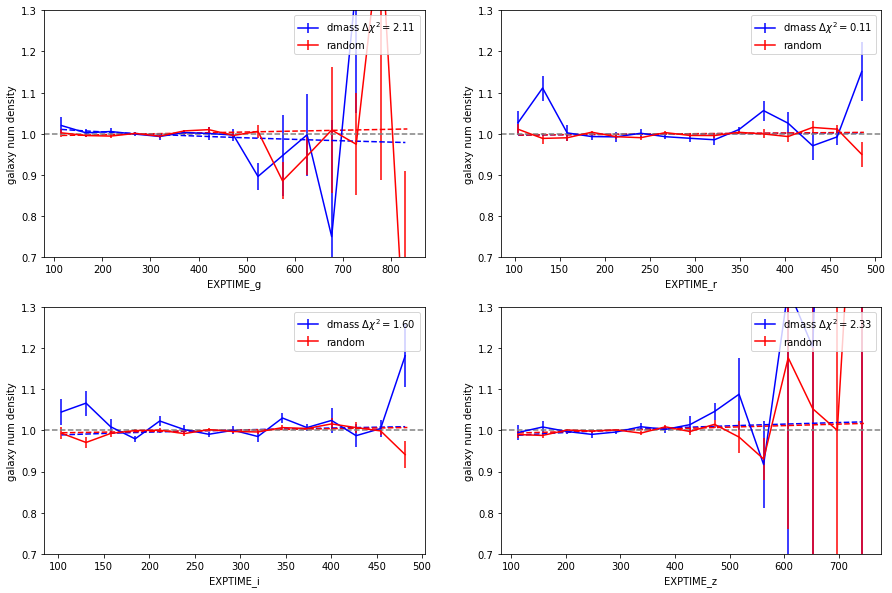

In [257]:
path = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
fitting_SP( property = ['EXPTIME'], filter=['g', 'r', 'i', 'z'], kind = 'SPT', suffix='1', plot=True, path=path
          , function = 'sqrt')

chi2_null =  19.526183908416563
chi2_mod. =  19.50831017162853
Delta chi2 (sample) = 0.017873736788033057
Delta_chi2_68 =  0.17096820934160206
significance =  0.10454421238231804
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_g_SPT_1.txt.model

chi2_null =  25.099963652817443
chi2_mod. =  25.071801177042712
Delta chi2 (sample) = 0.028162475774731632
Delta_chi2_68 =  0.0012518006669564841
significance =  22.497572112022716
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_r_SPT_1.txt.model

chi2_null =  103.92145935423284
chi2_mod. =  29.107457293211226
Delta chi2 (sample) = 74.81400206102161
Delta_chi2_68 =  0.20138319690233816
significance =  371.5007170995654
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_i_SPT_1.txt.model

chi2_null =  9.364475420953502
chi2_mod. =  8.82816848831624
Delta chi2 (sample) = 0.5363069326372614
Delta_chi

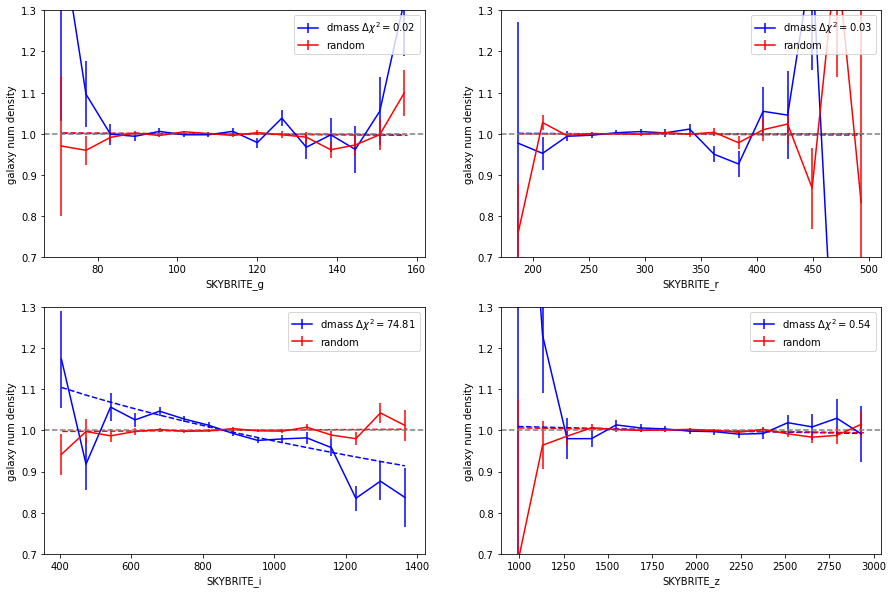

In [258]:
path = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
fitting_SP( property = ['SKYBRITE'], filter=['g', 'r', 'i', 'z'], kind = 'SPT', suffix='1', plot=True, path=path
          , function = 'sqrt')

chi2_null =  19.526183908416563
chi2_mod. =  19.515005795246566
Delta chi2 (sample) = 0.011178113169997062
Delta_chi2_68 =  0.17096820934160206
significance =  0.0653812379099245
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_g_SPT_1.txt.model

chi2_null =  25.099963652817443
chi2_mod. =  25.03038974111883
Delta chi2 (sample) = 0.06957391169861182
Delta_chi2_68 =  0.0012518006669564841
significance =  55.5790658490122
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_r_SPT_1.txt.model

chi2_null =  103.92145935423284
chi2_mod. =  27.105782581071626
Delta chi2 (sample) = 76.81567677316121
Delta_chi2_68 =  0.20138319690233816
significance =  381.44034832465877
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_i_SPT_1.txt.model

chi2_null =  9.364475420953502
chi2_mod. =  8.874851330390719
Delta chi2 (sample) = 0.4896240905627831
Delta_chi2_

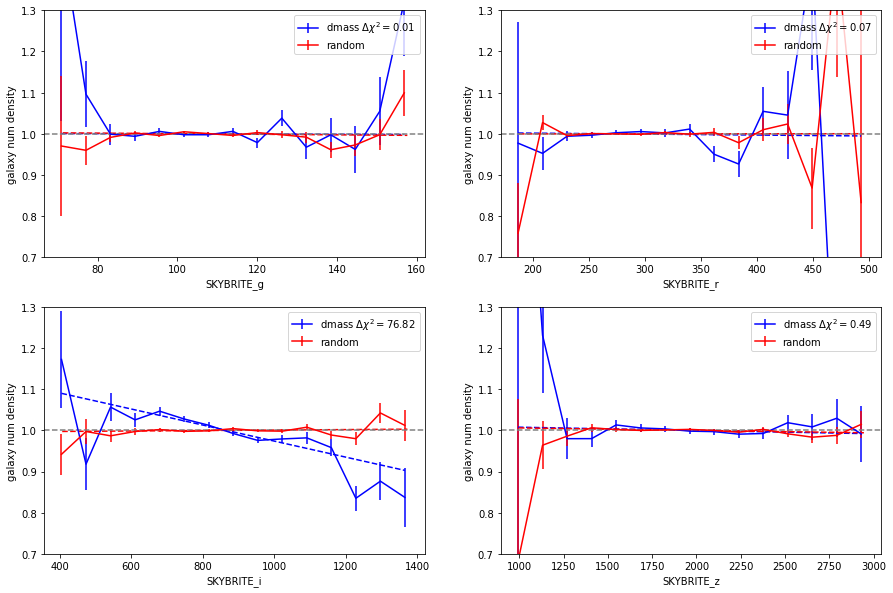

In [259]:
path = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
fitting_SP( property = ['SKYBRITE'], filter=['g', 'r', 'i', 'z'], kind = 'SPT', suffix='1', plot=True, path=path
          , function = 'linear')

chi2_null =  28.421702470954955
chi2_mod. =  26.421319964984367
Delta chi2 (sample) = 2.000382505970588
Delta_chi2_68 =  0.7618953296120156
significance =  2.6255345429000787
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_g_SPT_1.txt.model

chi2_null =  207.9884262576964
chi2_mod. =  41.375808421314744
Delta chi2 (sample) = 166.61261783638167
Delta_chi2_68 =  0.11927534951972839
significance =  1396.8738595800435
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_r_SPT_1.txt.model

chi2_null =  98.1700674438283
chi2_mod. =  19.34764661705521
Delta chi2 (sample) = 78.82242082677308
Delta_chi2_68 =  0.0021557771418065385
significance =  36563.34381610522
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_i_SPT_1.txt.model

chi2_null =  56.85613405050063
chi2_mod. =  43.08551984759613
Delta chi2 (sample) = 13.770614202904497
Delta_chi2_68 =  0.05449562028

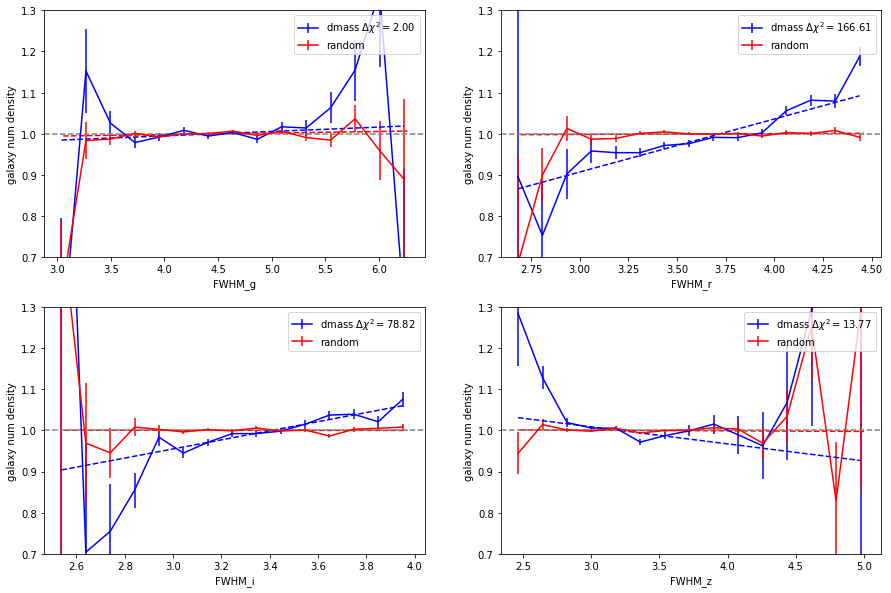

In [353]:
path = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
fitting_SP( property = ['FWHM'], filter=['g', 'r', 'i', 'z'], kind = 'SPT', suffix='1', plot=True, path=path
          , function = 'linear')

In [18]:
def plotting_significance( property = None, filter=None, kind = None, suffix='', 
                path = '../data_txt/systematics/', deltachi2 = False):

   
    import scipy
    
    key = 'significance'
    if deltachi2 : key = 'Delta chi2 (sample)'
    label = []
    siglist = []
    for p in property : 

        for f in filter : 
            filename = path+'systematic_'+p+'_'+f+'_'+kind+'_'+suffix+'.txt.model'
            file = open(filename, 'r')
            data = file.readlines()
            for s in data : 
                if key in s.split('#')[1] : 
                    sig = s.split('=')[1]
                    siglist.append( float(sig) )
                    label.append( p+'_'+f )
                    #print  p+'_'+f , sig
                    break
       
    arg = np.argsort(np.array(siglist), kind='quicksort')[::-1]
    #print arg
    #siglist = siglist[arg]
    #label = label[arg]
    siglist = [siglist[a] for a in arg]
    label = [label[a] for a in arg]
    print siglist
    fig, ax = plt.subplots(figsize = (7,7))
    ax.plot( siglist, np.arange( len(siglist) ),  'o'  )
    ax.axvline(x = 2, ls = '--', color='k')
    ax.axvline(x = 3, ls = '--', color='k')
    ax.set_xlim(0.01,1000)
    ax.set_xlabel(key)
    ax.set_yticks( np.arange( len(siglist) ))
    ax.set_yticklabels(label)
    ax.set_xscale('log')
    return label, siglist
         

[71.7882547843243, 45.44740208707442, 27.161597641597282, 26.887097796462918, 21.366070594478604, 18.893653891493344, 10.732743463445132, 8.4234263435036, 7.560039360821456, 4.410625078921322, 4.213893695846611, 3.756774006666019, 2.7466151055695676, 1.9621951212190218, 0.9317811437941934, 0.9105905474557439, 0.7071815569598598, 0.2845452569694018, 0.2164815970567986, 0.05198834828646426]


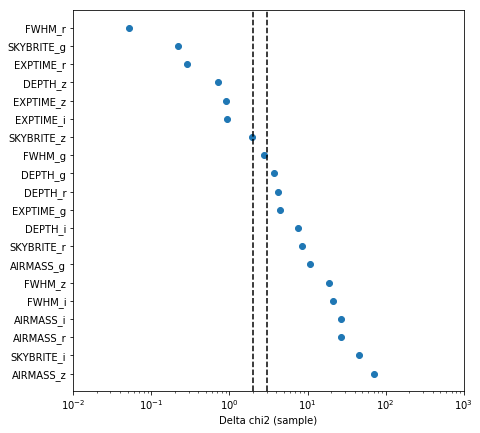

In [397]:
path = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
nextweight = plotting_significance( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM'], filter=['g', 'r', 'i','z'], kind = kind, suffix=suffix, 
                path = path, deltachi2=True)

[36563.34381610522, 2944.1392174597736, 1396.8738595800435, 381.44034832465877, 252.69212700482385, 193.78986408503744, 106.19826799804885, 56.69813627233241, 55.5790658490122, 34.39353103977977, 14.503320407122645, 2.6255345429000787, 1.809610743273977, 0.833875819243781, 0.7603379436470278, 0.7530078895063359, 0.5544899916095869, 0.24088621326915882, 0.2094433609066743, 0.0653812379099245]


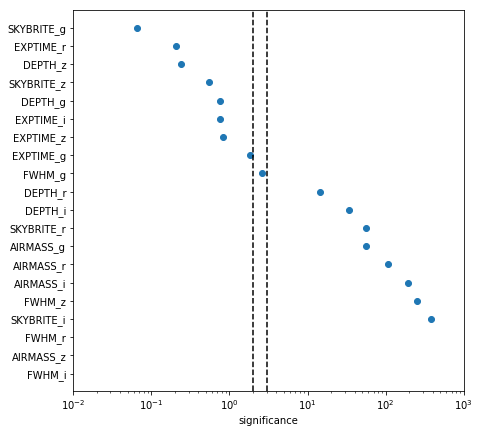

In [355]:
suffix = '1'
path = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
plotting_significance( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM'], filter=['g', 'r', 'i','z'], kind = kind, suffix=suffix, 
                path = path, deltachi2=False)

# FWHM r

In [19]:
def init( nextweight ):
  
    nextprop, nextfil = nextweight.split('_')
    print '----------------------------------'
    print 'initialize function ', nextweight
    #function = 'linear'
    if nextprop == 'EXPTIME' : function = 'sqrt'
    elif nextprop == 'SKYBRITE' : function = 'sqrt'
    else : function = 'linear'
        
    return nextprop, nextfil, function

In [24]:
def sys_iteration( nextweight=None, suffix=None, all_weight = None ):
    
    nextprop, nextfil, function = init(nextweight)

    wg = calculate_weight( property = [nextprop], filter=[nextfil], kind = kind, suffix=suffix, plot=True, 
                              function = 'linear',
                    path =path, catalog = dmass, sysMap= sysMap, 
                    weight=True, raTag ='RA', decTag='DEC', nside=4096)
    print 'store weight ', nextweight
    fitsname = path+'/weights/wg_'+nextweight.lower()+'_'+kind+'.fits'
    print 'save weight to fits', fitsname
    fitsio.write( fitsname, wg, clobber=True )
    weightDic[nextweight] = wg
    
    
    if suffix == '1': suffix = 'wg_'+nextweight.lower()
    else : suffix = suffix+'_'+nextweight.lower()
    print 'suffix = ', suffix
    all_weight = np.multiply( all_weight, weightDic[nextweight] )

    sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap, 
             FullArea = SPTMaparea, properties = properties, kind='SPT', nbins = 15,
             pixelmask = all_mask, reweight = all_weight, 
             suffix=suffix, outdir=path)

    fitting_SP( property = properties, filter=filters, kind = 'SPT', suffix=suffix, plot=False, path=path
              , function = 'linear')
    nextweight_new, deltachi2_new = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suffix, 
                    path = path, deltachi2=True)
    
    j = 0
    for i in range(len(nextweight_new)):
        if nextweight == nextweight_new[j]: j += 1
        else : break
    
    nextweight = nextweight_new[j]
    deltachi2 = deltachi2_new[j]
    
    return nextweight, suffix, all_weight, deltachi2

In [25]:
properties = ['DEPTH', 'EXPTIME', 'SKYBRITE', 'AIRMASS', 'FWHM']
filters = ['g', 'r', 'i', 'z']
path = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
weightDic = {}
weightDic['noweight'] = np.ones(dmass.size)
all_weight = weightDic['noweight']
suffix = '1'
nextweight = 'AIRMASS_z'

In [ ]:
max_iter = 200
i = 0
for i in range(max_iter):
    print ''
    print 'ITERATION-',i
    print ''
    nextweight, suffix, all_weight, deltachi2 = \
    sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )
    if deltachi2 < 3: break
    i += 1


ITERATION- 0

----------------------------------
initialize function  AIRMASS_z
chi2_null =  98.9055335364578
chi2_mod. =  38.57876952027861
Delta chi2 (sample) = 60.32676401617918
Delta_chi2_68 =  0.020490459030748413
significance =  2944.1392174597736
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_AIRMASS_z_SPT_1.txt.model

store weight  AIRMASS_z
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_airmass_z_SPT.fits
suffix =  wg_airmass_z


../systematics.py:433: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:433: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z.txt


../systematics.py:429: RuntimeWarning: invalid value encountered in divide
  Ngal_avg = Ngal *1./Nrand


saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_z_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_g_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_r_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_i_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_z_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_g_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_r_SPT_wg_airmass_z.txt
saving data to  ../data_txt/system


ITERATION- 1

----------------------------------
initialize function  FWHM_r
chi2_null =  218.08285544633054
chi2_mod. =  40.96944731782668
Delta chi2 (sample) = 177.11340812850386
Delta_chi2_68 =  0.022826803330823042
significance =  7759.01056147216
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_r_SPT_wg_airmass_z.txt.model

store weight  FWHM_r
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_fwhm_r_SPT.fits
suffix =  wg_airmass_z_fwhm_r
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmass_z_fwhm_r.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/sys


ITERATION- 2

----------------------------------
initialize function  AIRMASS_i
chi2_null =  122.73797324001359
chi2_mod. =  41.23377683197453
Delta chi2 (sample) = 81.50419640803906
Delta_chi2_68 =  0.06315896287010823
significance =  1290.4612853706822
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_AIRMASS_i_SPT_wg_airmass_z_fwhm_r.txt.model

store weight  AIRMASS_i
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_airmass_i_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r_airmass_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmass_z_fwhm_r_airmass_i.txt
saving data to  ../data

chi2_null =  40.22511021933208
chi2_mod. =  32.08702774243939
Delta chi2 (sample) = 8.138082476892691
Delta_chi2_68 =  0.012126844318778042
significance =  671.0799828023786
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_g_SPT_wg_airmass_z_fwhm_r_airmass_i.txt.model

chi2_null =  38.285599348560716
chi2_mod. =  38.01941846633787
Delta chi2 (sample) = 0.26618088222284797
Delta_chi2_68 =  0.022826803330823042
significance =  11.660891731757456
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_r_SPT_wg_airmass_z_fwhm_r_airmass_i.txt.model

chi2_null =  34.01293096496684
chi2_mod. =  26.118880669444817
Delta chi2 (sample) = 7.894050295522025
Delta_chi2_68 =  0.18727283716622276
significance =  42.152671017181696
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_i_SPT_wg_airmass_z_fwhm_r_airmass_i.txt.model

chi2_null =  44.20756138656334
chi2_mod. =  37.

/n/home00/lee.5922/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



ITERATION- 3

----------------------------------
initialize function  SKYBRITE_i
chi2_null =  45.13475801017013
chi2_mod. =  27.47258267728147
Delta chi2 (sample) = 17.662175332888662
Delta_chi2_68 =  0.015958204450242874
significance =  1106.7771056548818
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_i_SPT_wg_airmass_z_fwhm_r_airmass_i.txt.model

store weight  SKYBRITE_i
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_skybrite_i_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i_skybrite_i
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmas

chi2_null =  43.966202522312656
chi2_mod. =  32.541851854953826
Delta chi2 (sample) = 11.42435066735883
Delta_chi2_68 =  0.012126844318778042
significance =  942.0711907440403
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt.model

chi2_null =  40.83543799994977
chi2_mod. =  39.810038261035146
Delta chi2 (sample) = 1.025399738914622
Delta_chi2_68 =  0.022826803330823042
significance =  44.92086447908474
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_r_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt.model

chi2_null =  31.314689162806328
chi2_mod. =  27.428136595590775
Delta chi2 (sample) = 3.8865525672155528
Delta_chi2_68 =  0.18727283716622276
significance =  20.753423860214504
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_i_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt.model

chi2_null =  

KeyboardInterrupt: 

----------------------------------
initialize function  AIRMASS_z
chi2_null =  98.9055335364578
chi2_mod. =  38.57876952027861
Delta chi2 (sample) = 60.32676401617918
Delta_chi2_68 =  0.020490459030748413
significance =  2944.1392174597736
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_AIRMASS_z_SPT_1.txt.model

store weight  AIRMASS_z
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_airmass_z_SPT.fits
suffix =  wg_airmass_z


../systematics.py:433: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:433: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_z_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_g_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_r_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_i_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_z_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/

FWHM_r wg_airmass_z


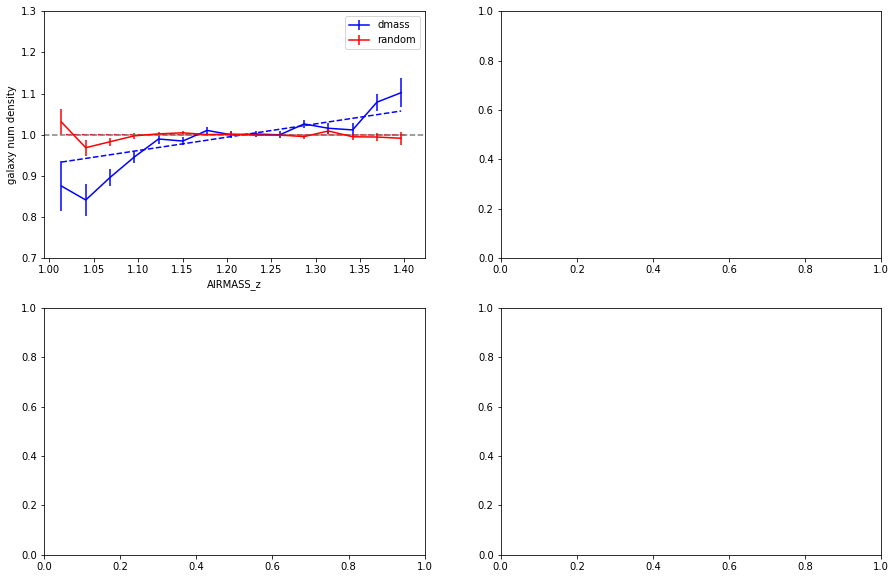

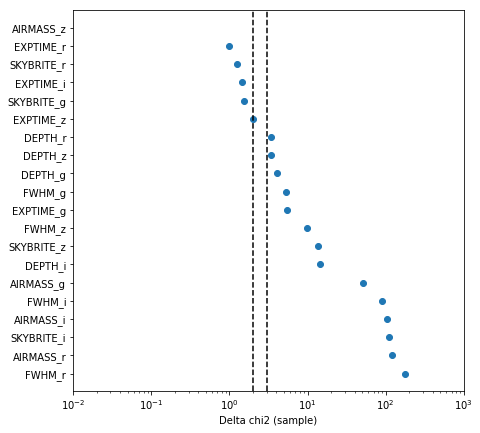

In [26]:
nextweight, suffix, all_weight, deltachi2 = \
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )
print nextweight, suffix

In [30]:
print nextweight
print suffix

FWHM_r
wg_airmass_z


----------------------------------
initialize function  FWHM_r
chi2_null =  216.4685433468373
chi2_mod. =  41.41717863697281
Delta chi2 (sample) = 175.0513647098645
Delta_chi2_68 =  0.18670652034977964
significance =  937.5749940704794
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_r_SPT_wg_airmass_z.txt.model

store weight  FWHM_r
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_fwhm_r_SPT.fits
suffix =  wg_airmass_z_fwhm_r
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmass_z_fwhm_r.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_z_S

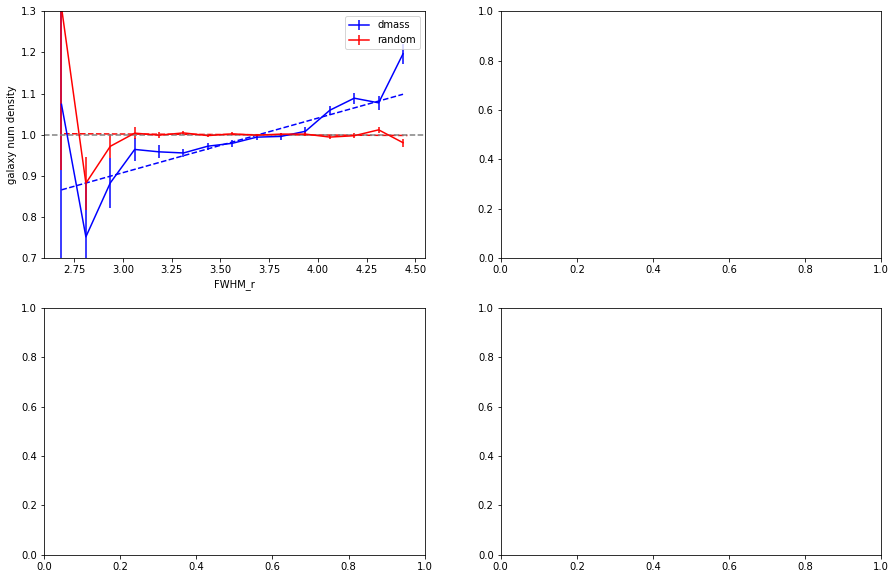

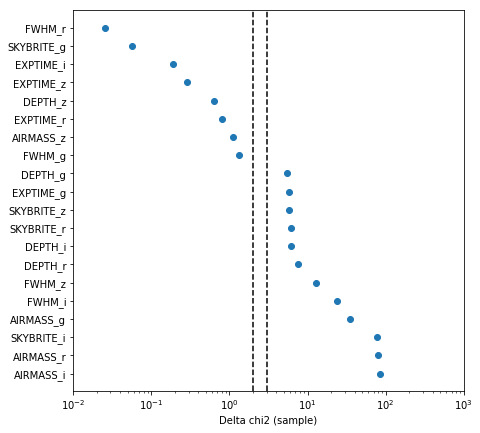

In [31]:
nextweight, suffix, all_weight, deltachi2 = \
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )


In [32]:
print nextweight
print suffix

AIRMASS_i
wg_airmass_z_fwhm_r


----------------------------------
initialize function  AIRMASS_i
chi2_null =  123.15365345772591
chi2_mod. =  38.61265904283283
Delta chi2 (sample) = 84.54099441489308
Delta_chi2_68 =  0.006173260396662528
significance =  13694.707331736528
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_AIRMASS_i_SPT_wg_airmass_z_fwhm_r.txt.model

store weight  AIRMASS_i
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_airmass_i_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r_airmass_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmass_z_fwhm_r_airmass_i.txt
saving data to  ../data_txt/systemati

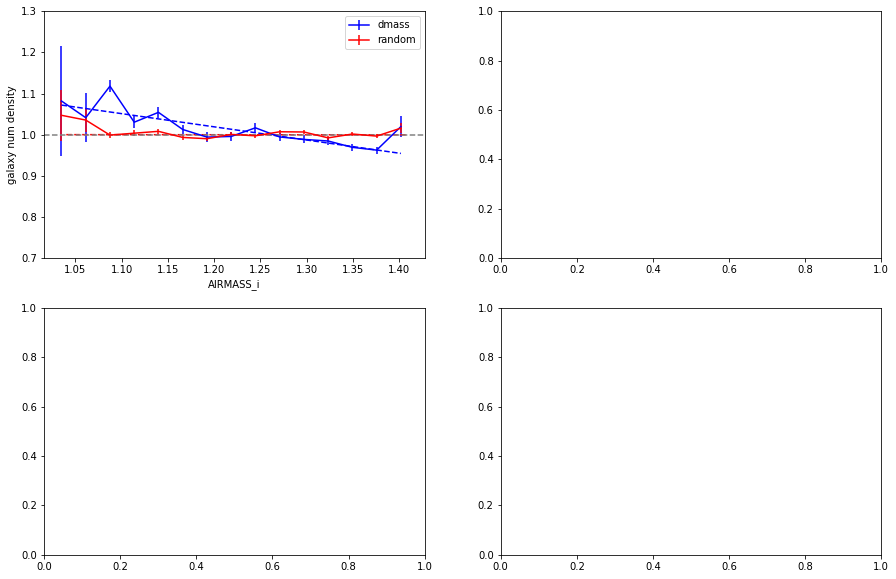

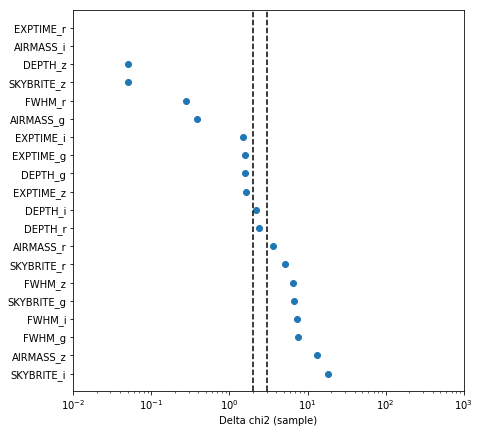

In [33]:
nextweight, suffix, all_weight, deltachi2 = \
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )

In [34]:
print nextweight
print suffix

SKYBRITE_i
wg_airmass_z_fwhm_r_airmass_i


----------------------------------
initialize function  SKYBRITE_i
chi2_null =  53.73031664239556
chi2_mod. =  35.511936947324635
Delta chi2 (sample) = 18.218379695070922
Delta_chi2_68 =  0.1626275856363735
significance =  112.02515012309311
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_i_SPT_wg_airmass_z_fwhm_r_airmass_i.txt.model

store weight  SKYBRITE_i
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_skybrite_i_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i_skybrite_i
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmass_z_fwhm_r_airma

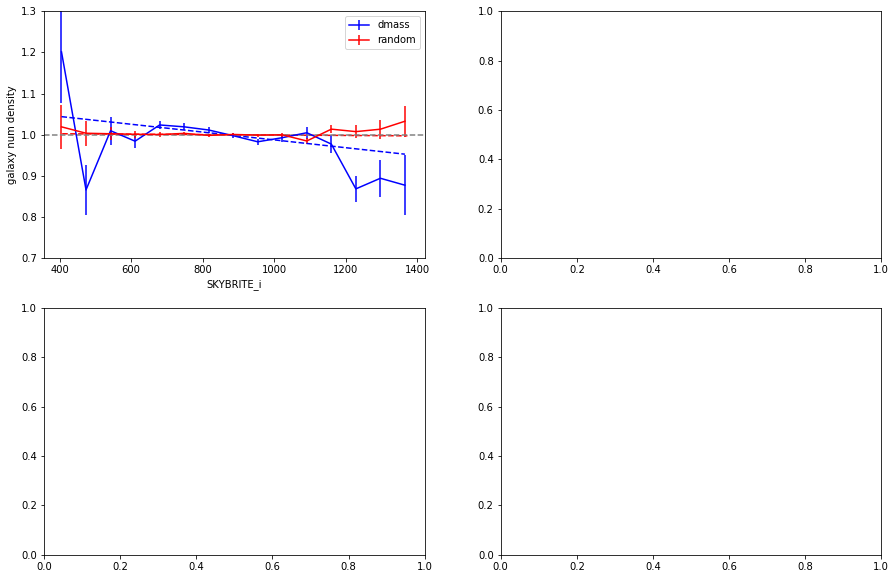

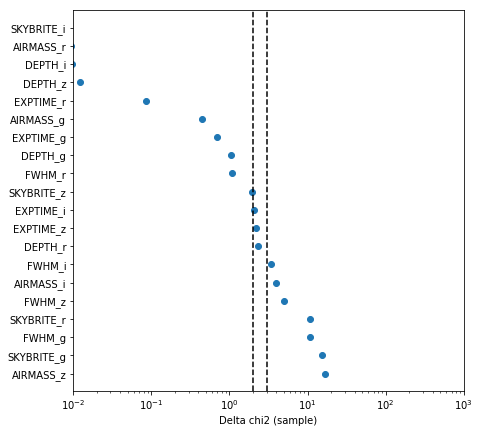

In [35]:
nextweight, suffix, all_weight, deltachi2 = \
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )

In [36]:
print nextweight
print suffix

AIRMASS_z
wg_airmass_z_fwhm_r_airmass_i_skybrite_i


In [42]:
nextweight = 'SKYBRITE_g'
print nextweight
print suffix

SKYBRITE_g wg_airmass_z_fwhm_r_airmass_i_skybrite_i


----------------------------------
initialize function  SKYBRITE_g
chi2_null =  31.738170490573992
chi2_mod. =  16.513970097256827
Delta chi2 (sample) = 15.224200393317165
Delta_chi2_68 =  0.02690854821299205
significance =  565.7756142327509
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt.model

store weight  SKYBRITE_g
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_skybrite_g_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/sys

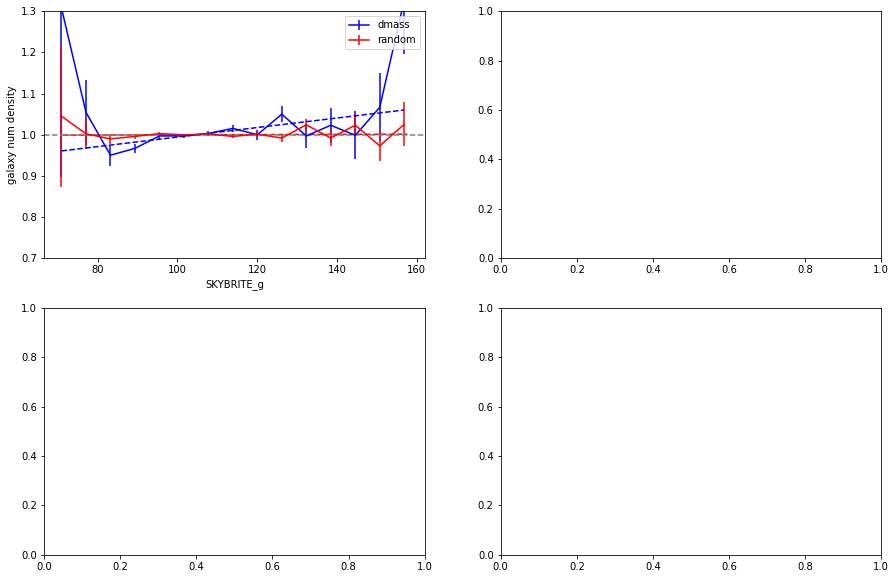

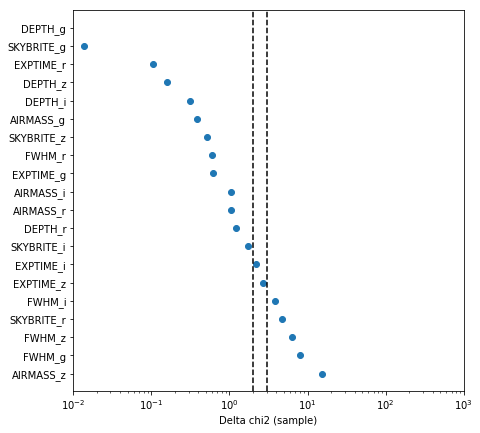

In [43]:
nextweight, suffix, all_weight, deltachi2 = \
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )

In [44]:
print nextweight
print suffix

AIRMASS_z
wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g


In [45]:
nextweight = 'FWHM_g'
print nextweight, suffix

FWHM_g wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g


----------------------------------
initialize function  FWHM_g
chi2_null =  38.238577371798804
chi2_mod. =  30.207042389116232
Delta chi2 (sample) = 8.031534982682572
Delta_chi2_68 =  0.45121016797940916
significance =  17.79998668613578
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g.txt.model

store weight  FWHM_g
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_fwhm_g_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_

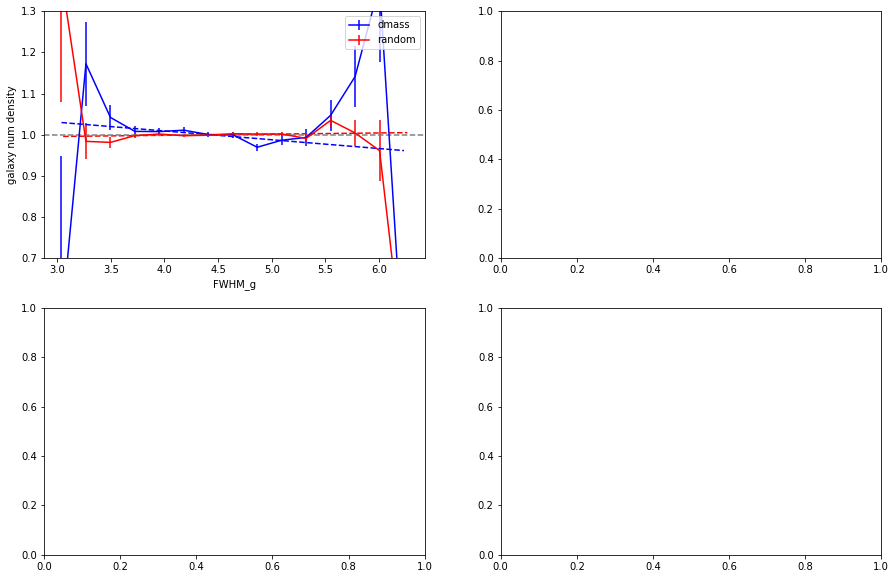

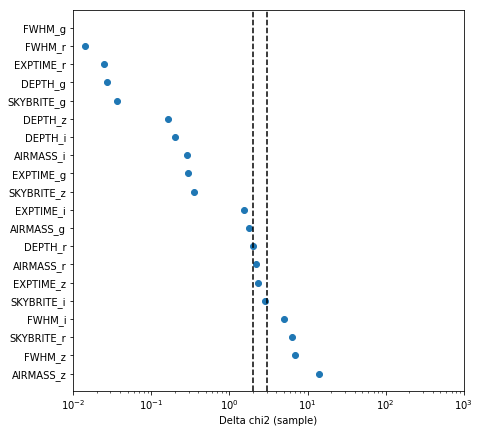

In [46]:
nextweight, suffix, all_weight, deltachi2 = \
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )

In [47]:
print nextweight
print suffix

AIRMASS_z
wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g


In [48]:
nextweight = 'FWHM_z'
print nextweight, suffix

FWHM_z wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g


----------------------------------
initialize function  FWHM_z
chi2_null =  41.37265369443948
chi2_mod. =  34.42900957057844
Delta chi2 (sample) = 6.943644123861041
Delta_chi2_68 =  0.9554832055123785
significance =  7.267154549448629
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_z_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g.txt.model

store weight  FWHM_z
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_fwhm_z_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z.txt
saving data to  ../data_txt/systematics/ex

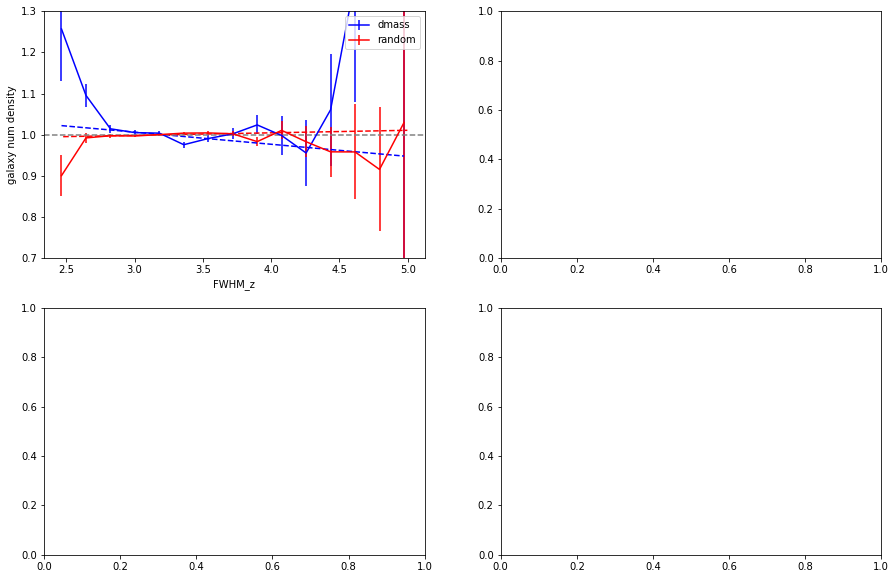

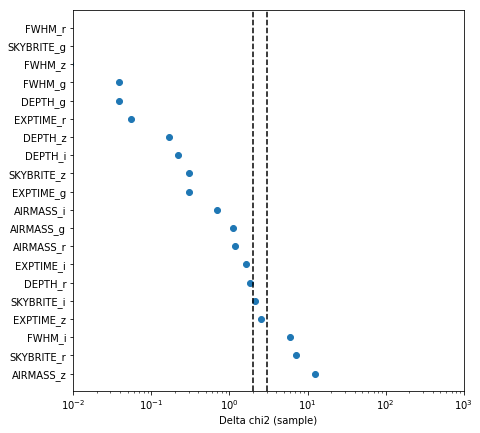

In [49]:
nextweight, suffix, all_weight, deltachi2 = \
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )

In [50]:
print nextweight
print suffix

AIRMASS_z
wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z


In [51]:
nextweight = 'SKYBRITE_r'
print nextweight, suffix

SKYBRITE_r wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z


----------------------------------
initialize function  SKYBRITE_r
chi2_null =  32.58569459090561
chi2_mod. =  25.393563268582962
Delta chi2 (sample) = 7.192131322322648
Delta_chi2_68 =  0.254453921806984
significance =  28.264965504356574
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_r_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z.txt.model

store weight  SKYBRITE_r
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_skybrite_r_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_

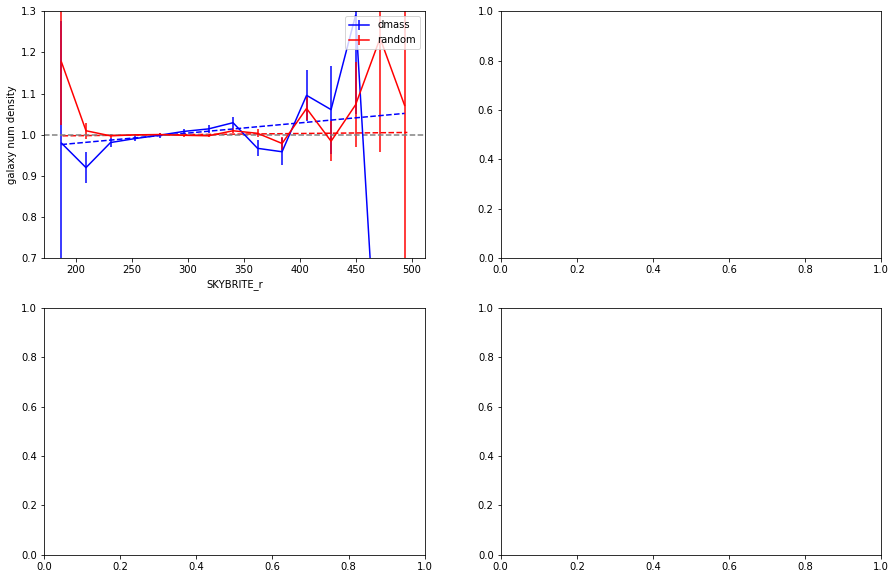

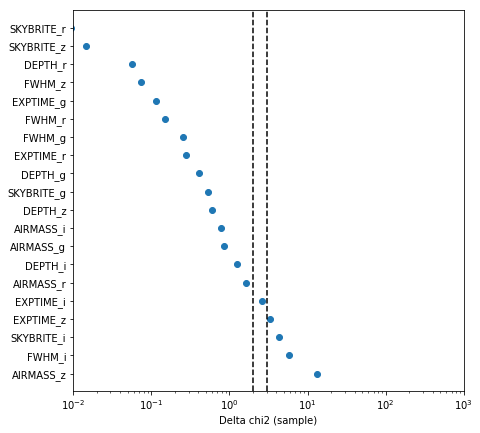

In [52]:
nextweight, suffix, all_weight, deltachi2 = \
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )

In [53]:
print nextweight
print suffix

AIRMASS_z
wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r


In [54]:
nextweight = 'FWHM_i'
print nextweight, suffix

FWHM_i wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r


----------------------------------
initialize function  FWHM_i
chi2_null =  32.69023714870947
chi2_mod. =  26.930810290408303
Delta chi2 (sample) = 5.759426858301168
Delta_chi2_68 =  0.5875888124755888
significance =  9.801798019325703
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_i_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r.txt.model

store weight  FWHM_i
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_fwhm_i_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_

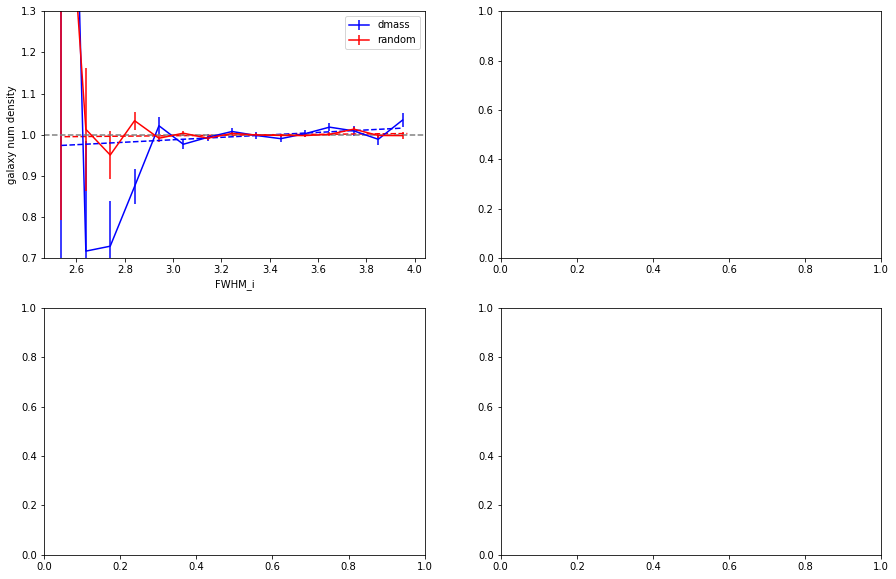

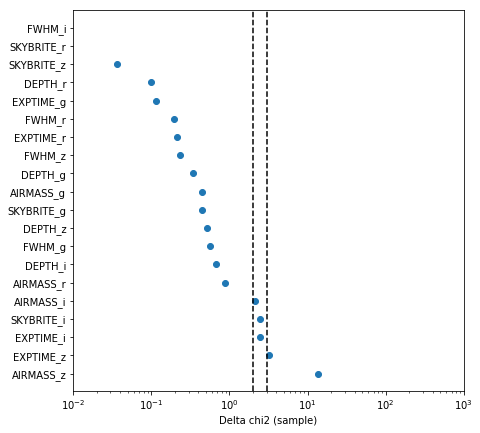

In [55]:
nextweight, suffix, all_weight, deltachi2 = \
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )

In [70]:
nextweight = 'EXPTIME_z'
print nextweight, suffix

EXPTIME_z wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i


----------------------------------
initialize function  EXPTIME_z
chi2_null =  14.270984018766717
chi2_mod. =  11.018553671059836
Delta chi2 (sample) = 3.2524303477068806
Delta_chi2_68 =  0.28239828070537065
significance =  11.517174749021146
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_z_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i.txt.model

store weight  EXPTIME_z
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_exptime_z_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_f

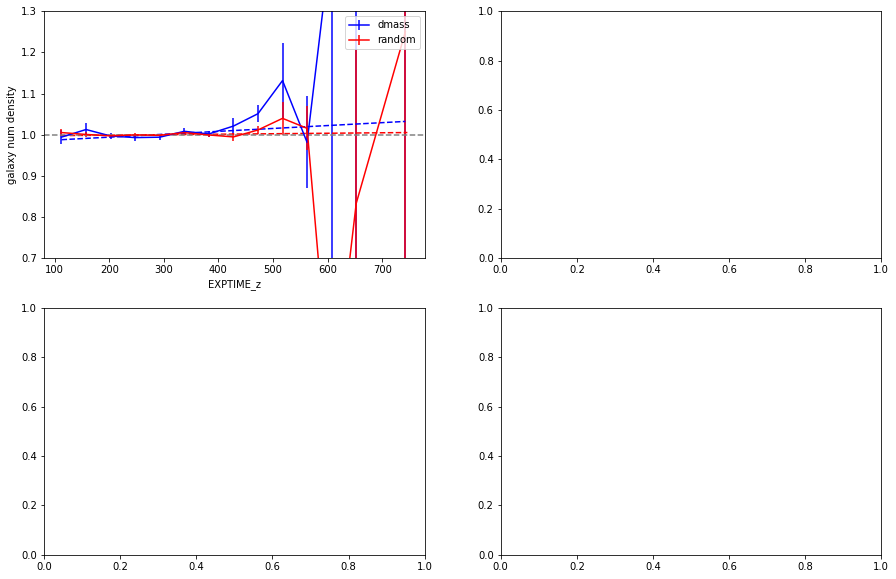

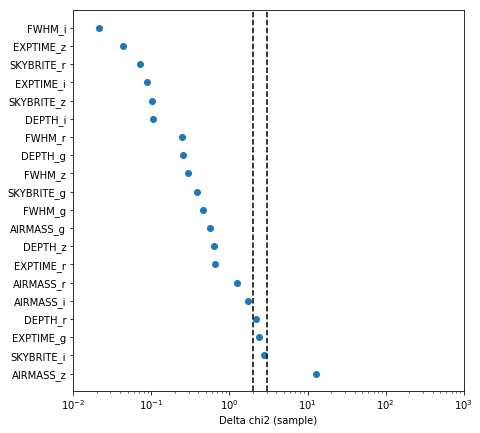

In [71]:
nextweight, suffix, all_weight, deltachi2 = \
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )

In [208]:
print nextweight
print suffix

AIRMASS_z
wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z


In [ ]:
nextweight = 'NSTARS_allband'
print nextweight, suffix

[166.61261783638167, 78.82242082677308, 76.81567677316121, 60.32676401617918, 50.458779943773806, 38.03879300021996, 19.538383038902047, 16.74504983688334, 13.770614202904497, 2.330702221569174, 2.107534081318377, 2.000382505970588, 1.5961878596218426, 0.8959901844430433, 0.4896240905627831, 0.2762933864983079, 0.19236483608333899, 0.10672276030948069, 0.06957391169861182, 0.011178113169997062]


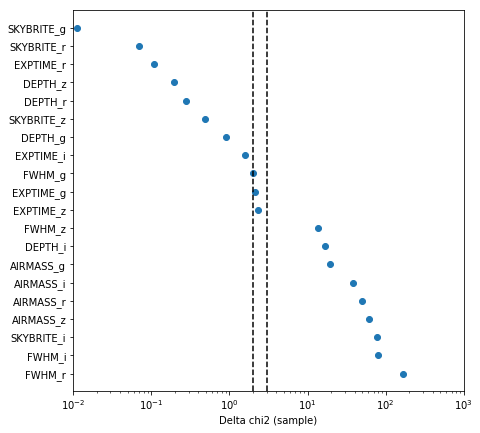

In [82]:
label_no_mask, values_no_mask = plotting_significance( property = properties, filter=filters, kind = kind, suffix='1', 
                    path = path, deltachi2=True)
#_ = plotting_significance( property = properties, filter=filters, kind = kind, suffix='1', 
#                    path = path, deltachi2=False)

[12.923182118542943, 2.794487614437827, 2.3878507029379037, 2.162573170681867, 1.7290554653467538, 1.235948925624207, 0.6582609019191423, 0.6284916467204447, 0.5638028640019819, 0.46347755314985406, 0.3792750014213766, 0.29673763231871675, 0.2520900524092937, 0.2476702039348453, 0.10543980569897116, 0.10179421833318436, 0.08796989151293388, 0.0713385220519065, 0.04286687125953037, 0.021227444649742466]


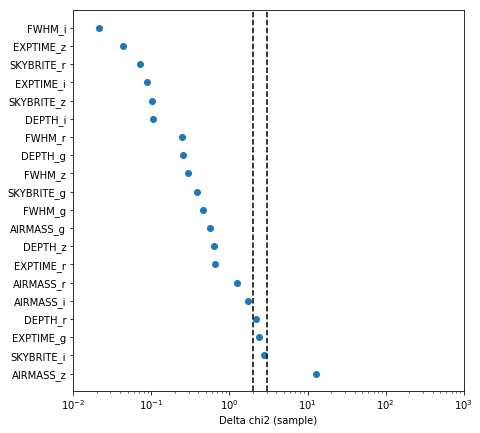

In [83]:
label_full_weight, values_full_weight = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suffix, 
                    path = path, deltachi2=True)
#_ = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suffix, 
#                    path = path, deltachi2=False)

In [86]:
arg = np.argsort(label_no_mask, kind='quicksort')[::-1]
arg2 = np.argsort(label_full_weight, kind='quicksort')[::-1]

In [95]:
values_no_mask_reorder = np.array(values_no_mask)[arg]

0

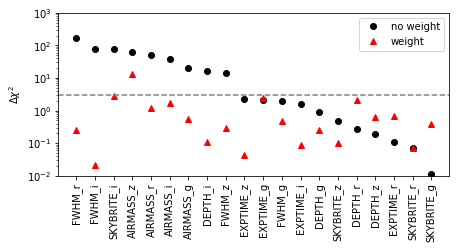

In [146]:

values_full_weight_reorder = []
for la in label_no_mask:
    for j in range(len(label_full_weight)):
        if la == label_full_weight[j]: 
            values_full_weight_reorder.append(values_full_weight[j])
            break

values_full_weight_reorder = np.array(values_full_weight_reorder)

fig, ax = plt.subplots(figsize = (7,3))

ax.plot( np.arange( len(values_no_mask) ), values_no_mask,  'ko' , label='no weight'  )
ax.plot( np.arange( len(values_no_mask) ), values_full_weight_reorder, 'r^', label='weight'  )


#ax.plot( values_no_mask, np.arange( len(values_no_mask) ),  'ko'  )
#ax.plot( values_full_weight_reorder, np.arange( len(values_no_mask) ),  'ro'  )
#ax.axhline(y = 1, ls = '--', color='grey')
ax.axhline(y = 3, ls = '--', color='grey')
ax.set_ylim(0.01,1000)
ax.set_ylabel(r'$\Delta \chi^2$')
ax.set_xticks( np.arange(len(values_no_mask)))
ax.set_xticklabels(label_no_mask, rotation = 90)
ax.set_yscale('log')
ax.legend(loc='best')
0

[36563.34381610522, 2944.1392174597736, 1396.8738595800435, 381.44034832465877, 252.69212700482385, 193.78986408503744, 106.19826799804885, 56.69813627233241, 55.5790658490122, 34.39353103977977, 14.503320407122645, 2.6255345429000787, 1.809610743273977, 0.833875819243781, 0.7603379436470278, 0.7530078895063359, 0.5544899916095869, 0.24088621326915882, 0.2094433609066743, 0.0653812379099245]


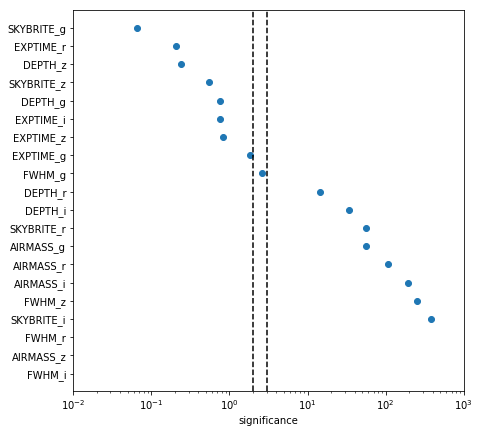

In [233]:
sig_label_no_mask, sig_values_no_mask = plotting_significance( property = properties, filter=filters, kind = kind, suffix='1', 
                    path = path, deltachi2=False)
#_ = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suffix, 
#                    path = path, deltachi2=False)

0

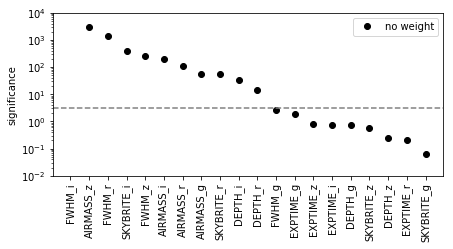

In [235]:

fig, ax = plt.subplots(figsize = (7,3))

ax.plot( np.arange( len(sig_values_no_mask) ), sig_values_no_mask,  'ko' , label='no weight'  )
#ax.plot( np.arange( len(values_no_mask) ), values_full_weight_reorder, 'r^', label='weight'  )
#ax.plot( values_no_mask, np.arange( len(values_no_mask) ),  'ko'  )
#ax.plot( values_full_weight_reorder, np.arange( len(values_no_mask) ),  'ro'  )
#ax.axhline(y = 1, ls = '--', color='grey')
ax.axhline(y = 3, ls = '--', color='grey')
ax.set_ylim(0.01,10000)
ax.set_ylabel('significance')
ax.set_xticks( np.arange(len(sig_label_no_mask)))
ax.set_xticklabels(sig_label_no_mask, rotation = 90)
ax.set_yscale('log')
ax.legend(loc='best')
0

In [68]:
#suffix = 'wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i'

saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_DEPTH_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_EXPTIME_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_SKYBRITE_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_AIRMASS_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_FWHM_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybri

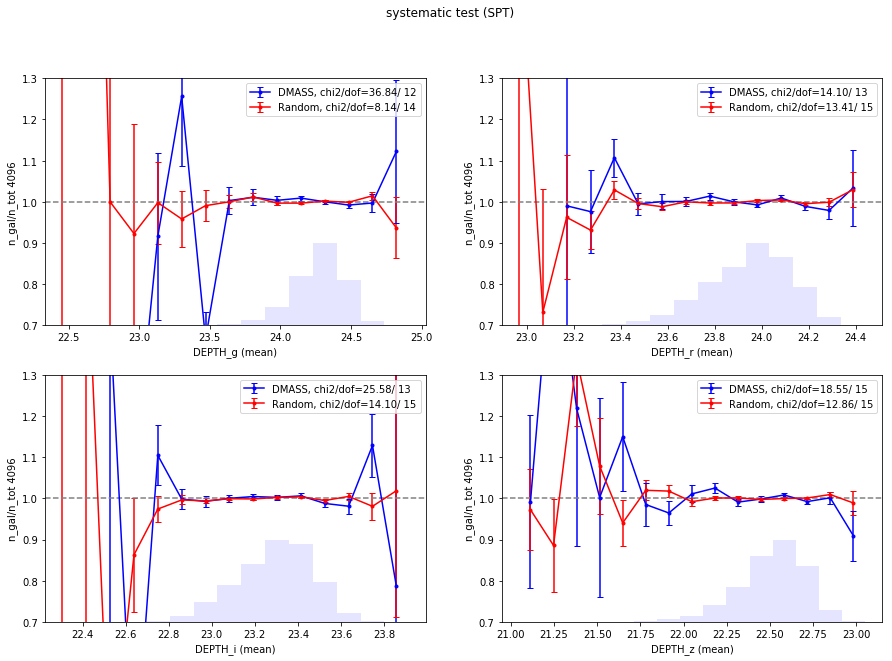

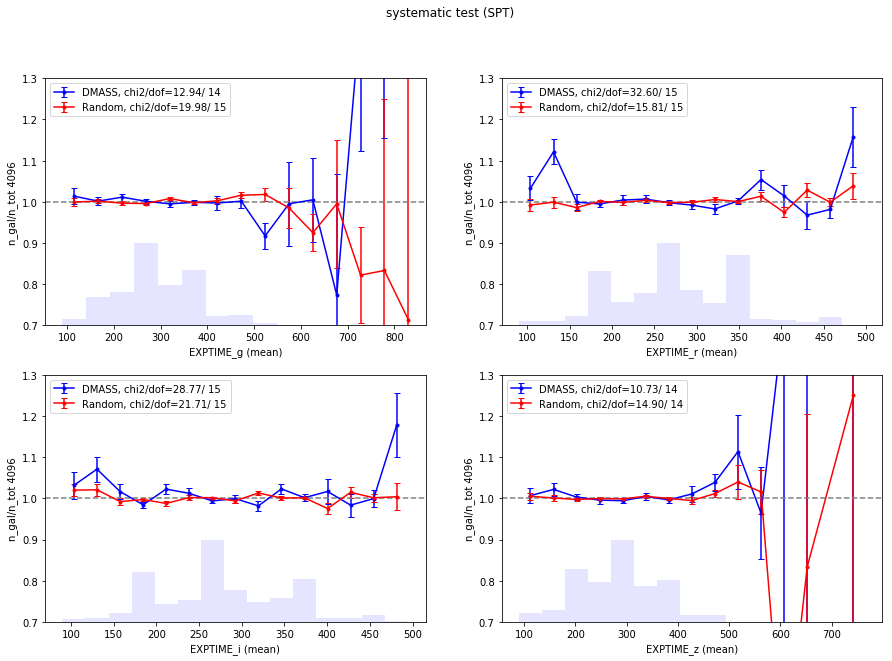

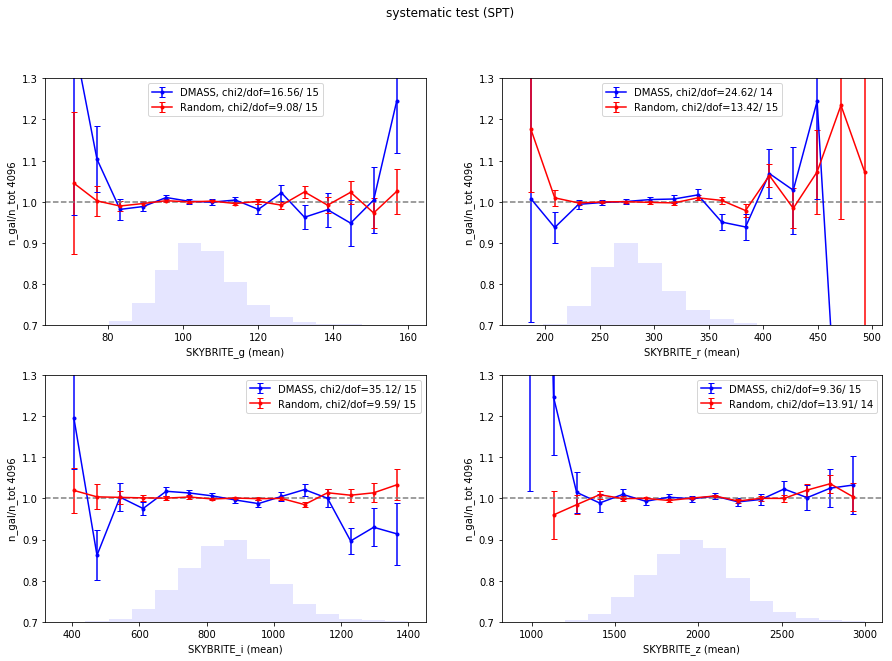

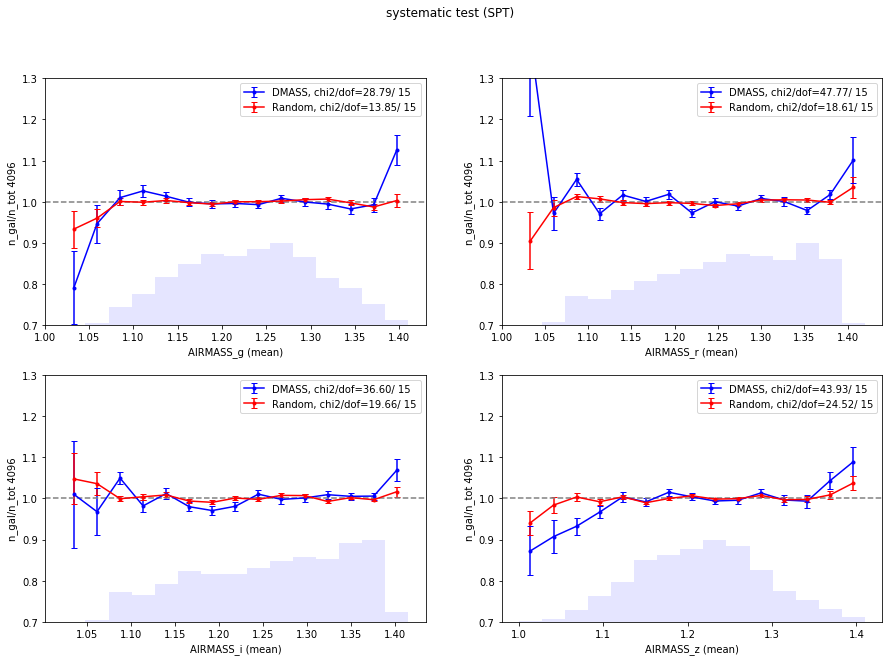

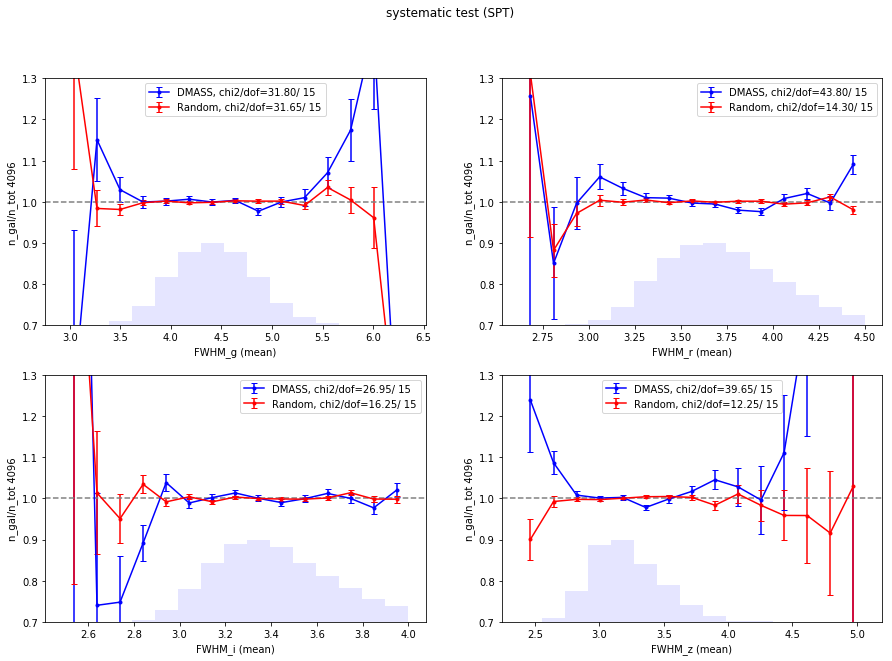

In [148]:
from systematics_module.contCorrection import doVisualization_ngal
inputdir = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
figoutdir = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/'

for p in properties: 
    doVisualization_ngal(property = p, nside = 4096, kind = kind, suffix=suffix, \
                         inputdir=inputdir, outdir=figoutdir)

In [209]:
sysMap_stellar = calling_sysMap( properties=['NSTARS_allband'], kind='SPT', nside = 1024 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
y1a1_gold_1.0.2_stars_nside1024.fits
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
DOWNGRADE =  1024


In [247]:
sysMap_ge = calling_sysMap( properties=['GE'], kind='SPT', nside = 512 )

In [249]:

sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_ge, 
         FullArea = SPTMaparea, properties = ['GE'], kind='SPT', nbins = 15, pixelmask = None,
         reweight= all_weight, nside = 512,
         suffix=suffix, outdir= '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/')

sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_ge, 
         FullArea = SPTMaparea, properties = ['GE'], kind='SPT', nbins = 15, pixelmask = None,
         reweight= None, nside = 512,
         suffix='1', outdir= '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/')

../systematics.py:442: RuntimeWarning: invalid value encountered in divide
  #try:
../systematics.py:446: RuntimeWarning: divide by zero encountered in divide
  norm_galaxy_density[Nrand == 0] = 0.0
../systematics.py:446: RuntimeWarning: invalid value encountered in multiply
  norm_galaxy_density[Nrand == 0] = 0.0


saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_GE_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_GE_g_SPT_1.txt


In [215]:
#fwhm_mask_st82 = (sysMap_st82['sys_FWHM_r_STRIPE82']['SIGNAL'] < 4.5) 
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_stellar, 
         FullArea = SPTMaparea, properties = ['NSTARS_allband'], kind='SPT', nbins = 30, pixelmask = None,
         reweight= all_weight, nside = 1024,
         suffix=suffix, outdir= '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/')

saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_NSTARS_allband_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.txt


In [216]:
#fwhm_mask_st82 = (sysMap_st82['sys_FWHM_r_STRIPE82']['SIGNAL'] < 4.5) 
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_stellar, 
         FullArea = SPTMaparea, properties = ['NSTARS_allband'], kind='SPT', nbins = 30, pixelmask = None,
         reweight= None, nside = 1024,
         suffix='1', outdir= '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/')

saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_NSTARS_allband_g_SPT_1.txt


IOError: ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//systematic_GE_r_SPT_1.txt not found.

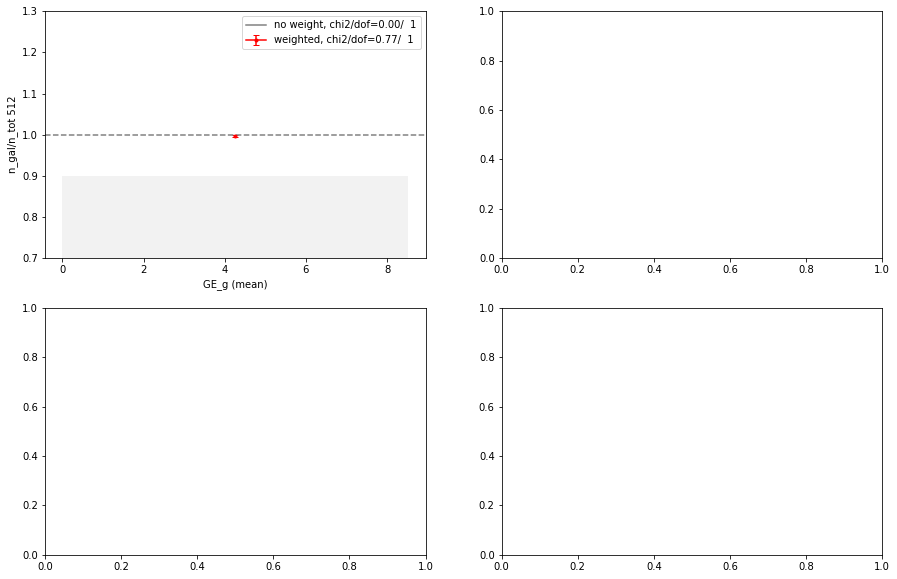

In [250]:
plot_sysweight(property = 'GE', nside = 512, kind = 'SPT', 
           suffix1='1', suffix2=suffix, inputdir1 = inputdir, inputdir2 = inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_NSTARS_allband_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png


0

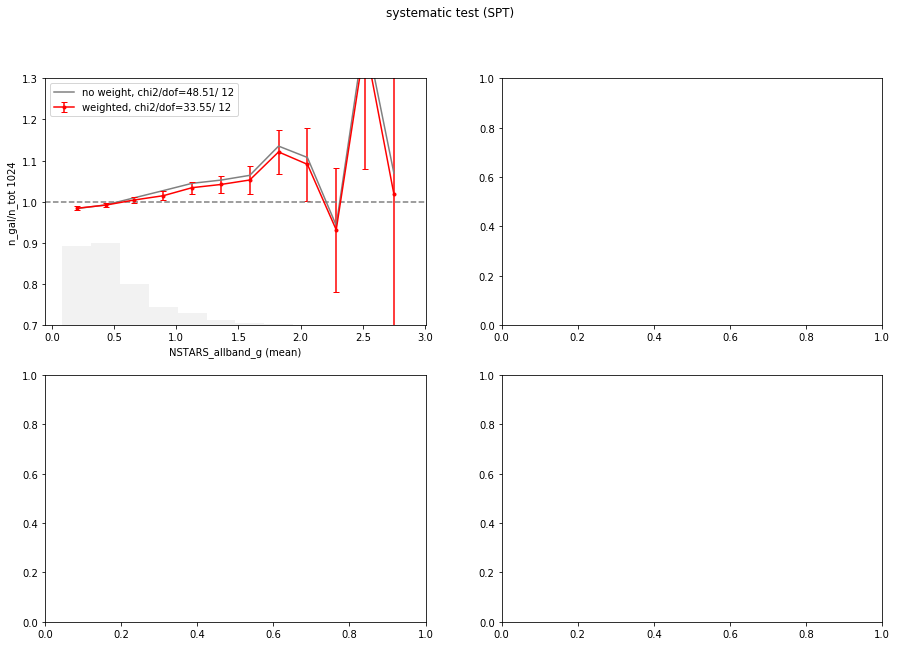

In [217]:
plot_sysweight(property = 'NSTARS_allband', nside = 1024, kind = 'SPT', 
           suffix1='1', suffix2=suffix, inputdir1 = inputdir, inputdir2 = inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_DEPTH_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_EXPTIME_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_SKYBRITE_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_AIRMASS_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_FWHM_SPT_wg_airmass_z_fwhm

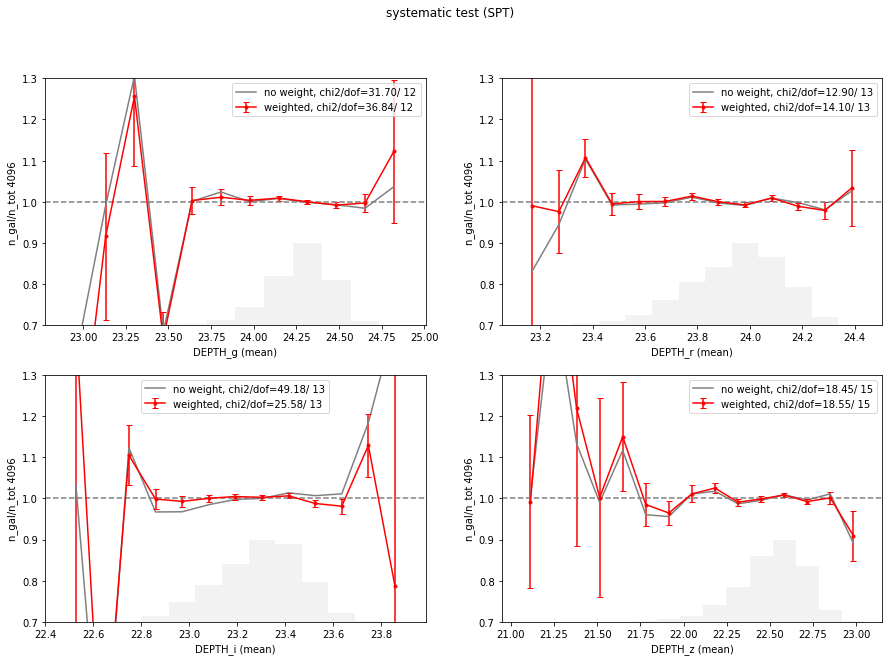

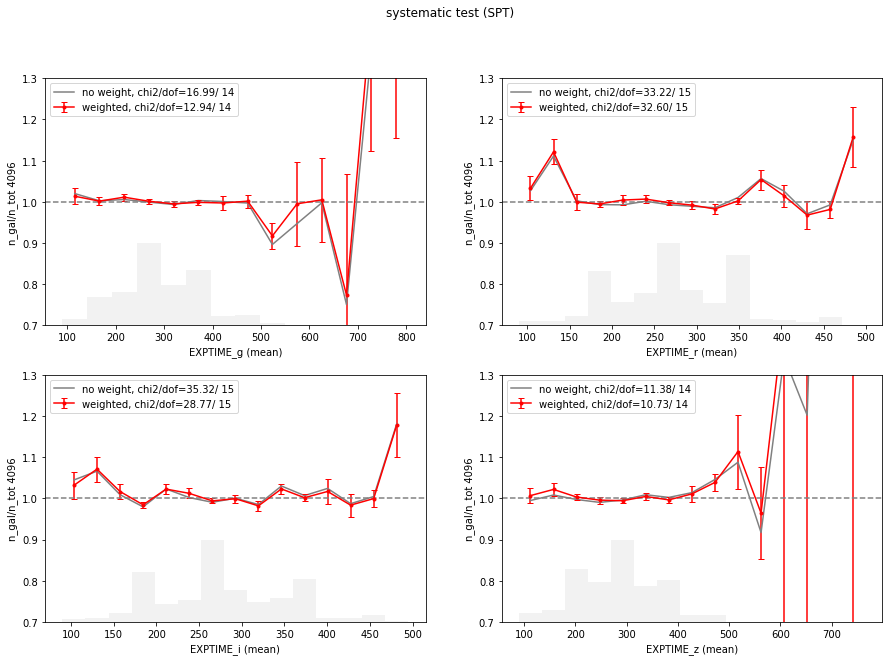

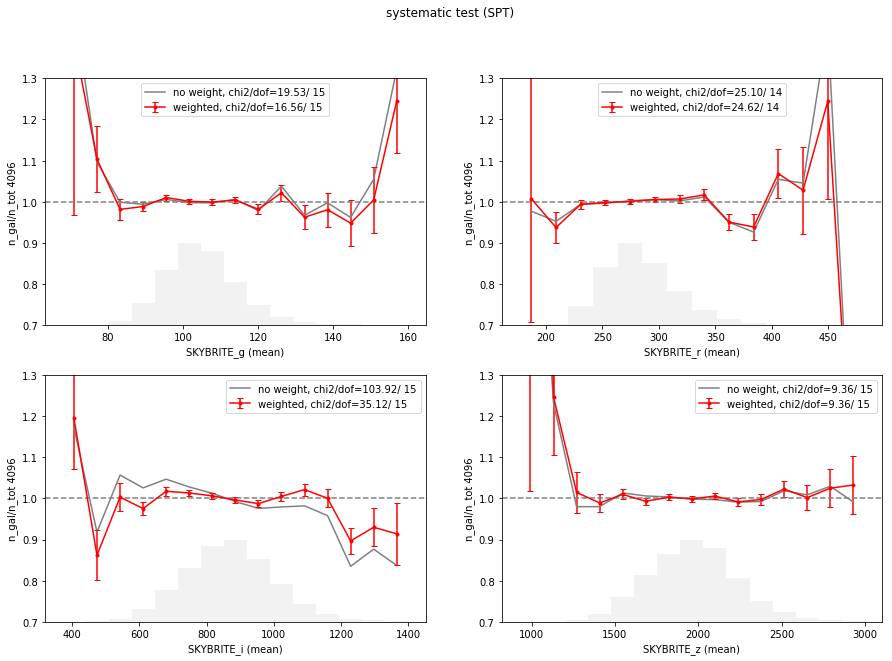

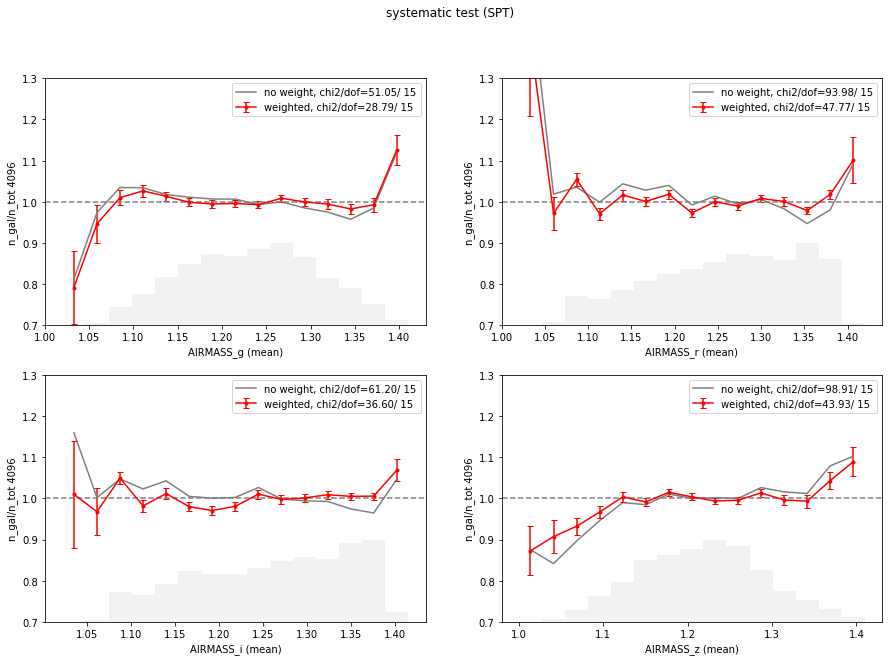

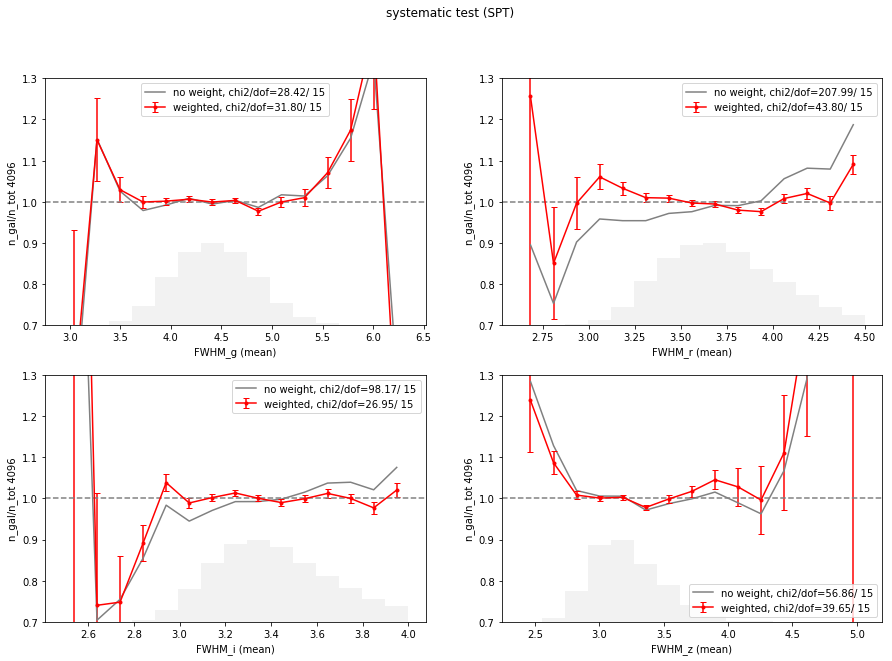

In [157]:
from systematics_module.contCorrection import plot_sysweight
for pr in properties:
    plot_sysweight(property = pr, nside = 4096, kind = 'SPT', 
               suffix1='1', suffix2=suffix, inputdir1 = inputdir, inputdir2 = inputdir, outdir=figoutdir)



saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_mask/figure/systematic_DEPTH_SPT_wg_fwhm_r.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_mask/figure/systematic_EXPTIME_SPT_wg_fwhm_r.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_mask/figure/systematic_AIRMASS_SPT_wg_fwhm_r.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_mask/figure/systematic_SKYBRITE_SPT_wg_fwhm_r.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_mask/figure/systematic_FWHM_SPT_wg_fwhm_r.png


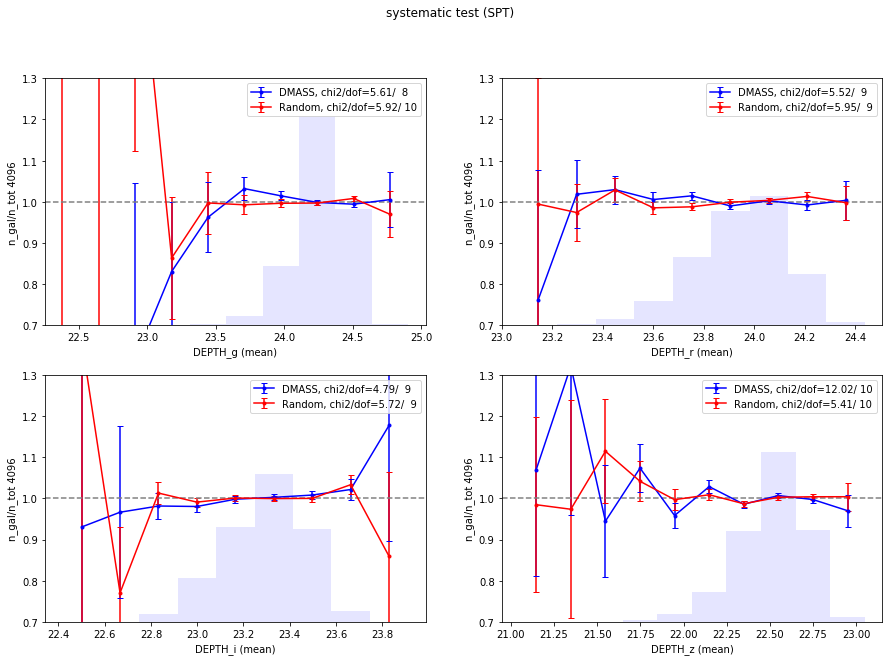

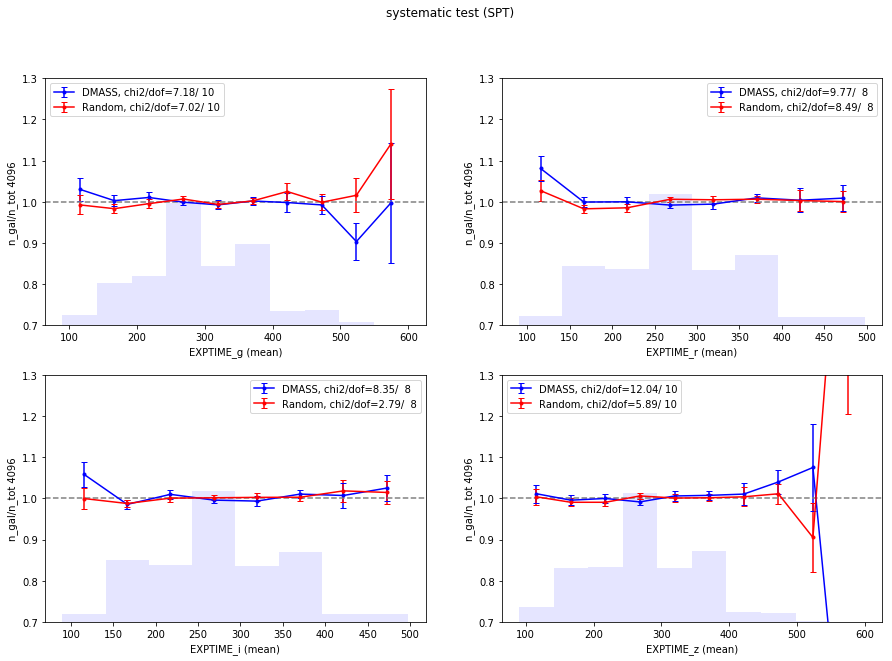

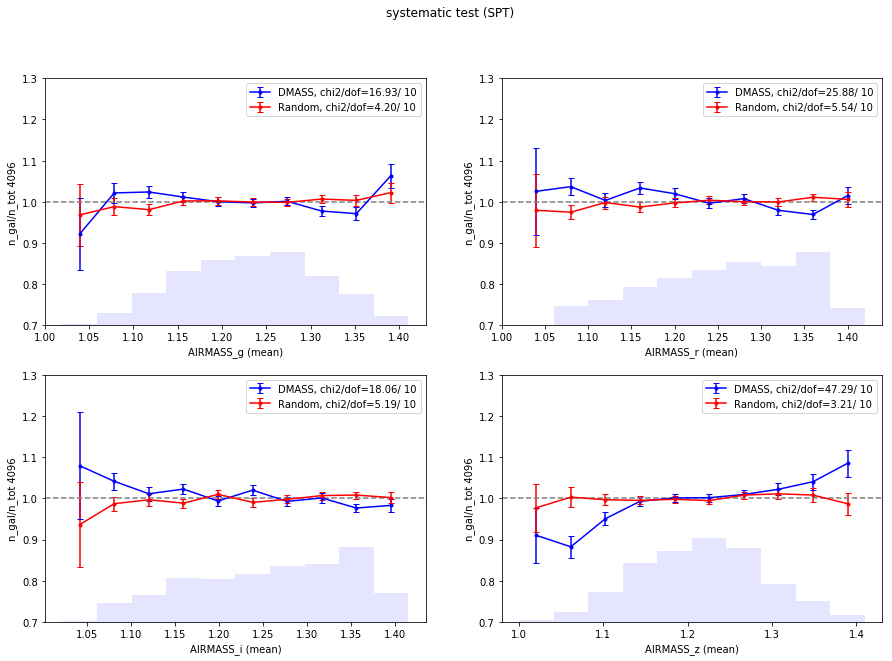

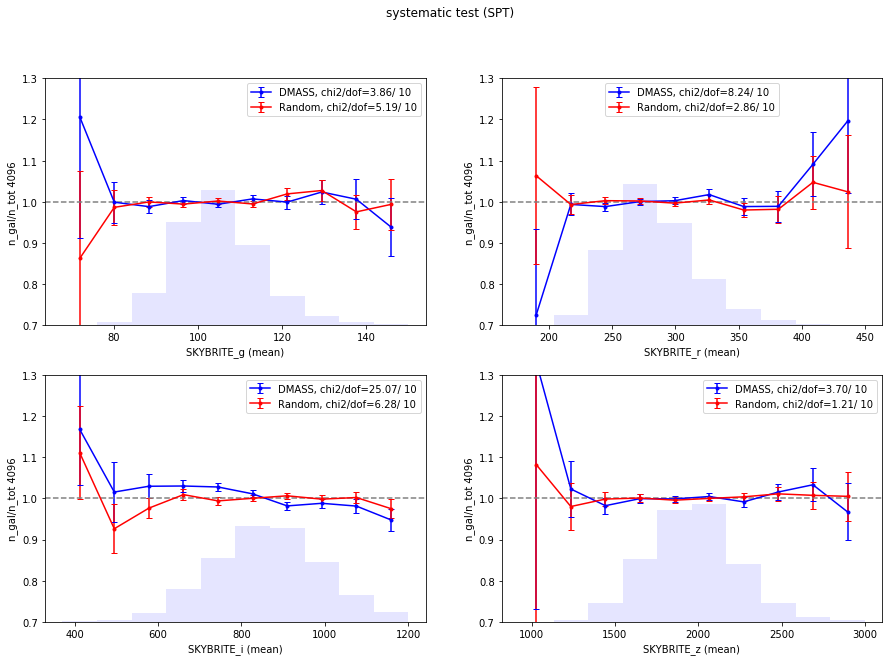

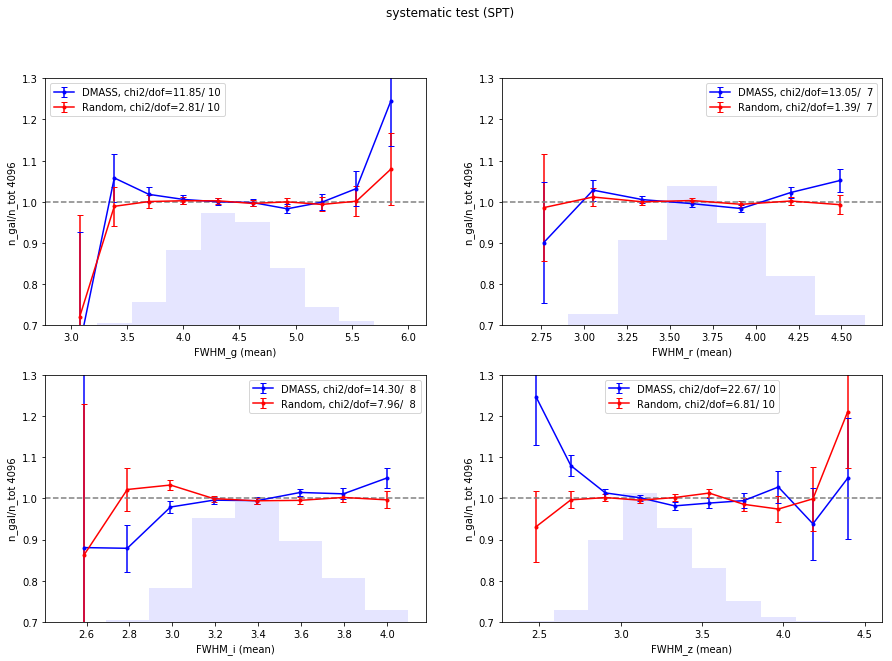

In [1107]:

inputdir = '../data_txt/systematics/exp_ri_fwhm_r_mask/'
figoutdir = '../data_txt/systematics/exp_ri_fwhm_r_mask/figure/'
suffix = 'wg_fwhm_r'

for p in properties: 
    doVisualization_ngal(property = p, nside = nside, kind = kind, suffix=suffix, inputdir=inputdir, outdir=figoutdir)

Delta chi2 (sample) = 4.411004380099801
Delta chi2 (random) = 1.9482883450887782
Delta_chi2_68 =  1.3248360746603693
significance =  3.329471822565363
output save to  ../data_txt/systematics/exp_ri_fwhm_r_mask/systematic_AIRMASS_g_SPT_wg_fwhm_r.txt.model

Delta chi2 (sample) = 14.798747924492478
Delta chi2 (random) = 3.650405387456334
Delta_chi2_68 =  2.482275663470307
significance =  5.961766512186369
output save to  ../data_txt/systematics/exp_ri_fwhm_r_mask/systematic_AIRMASS_r_SPT_wg_fwhm_r.txt.model

Delta chi2 (sample) = 11.888616021777391
Delta chi2 (random) = 1.993228775864928
Delta_chi2_68 =  1.3553955675881513
significance =  8.771325734030917
output save to  ../data_txt/systematics/exp_ri_fwhm_r_mask/systematic_AIRMASS_i_SPT_wg_fwhm_r.txt.model

Delta chi2 (sample) = 34.95265247557908
Delta chi2 (random) = 1.0127276583321563
Delta_chi2_68 =  0.6886548076658663
significance =  50.75496763617749
output save to  ../data_txt/systematics/exp_ri_fwhm_r_mask/systematic_AIRMASS_z_SP

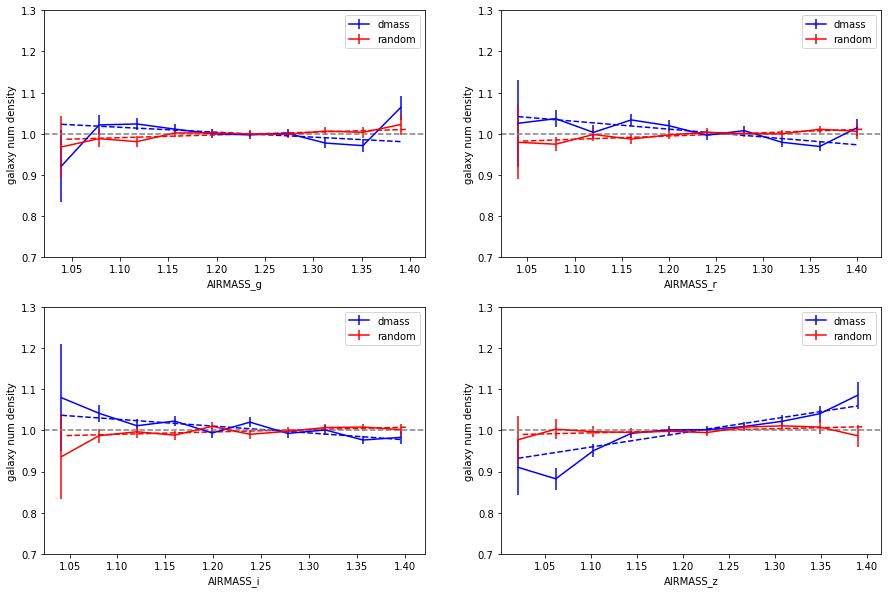

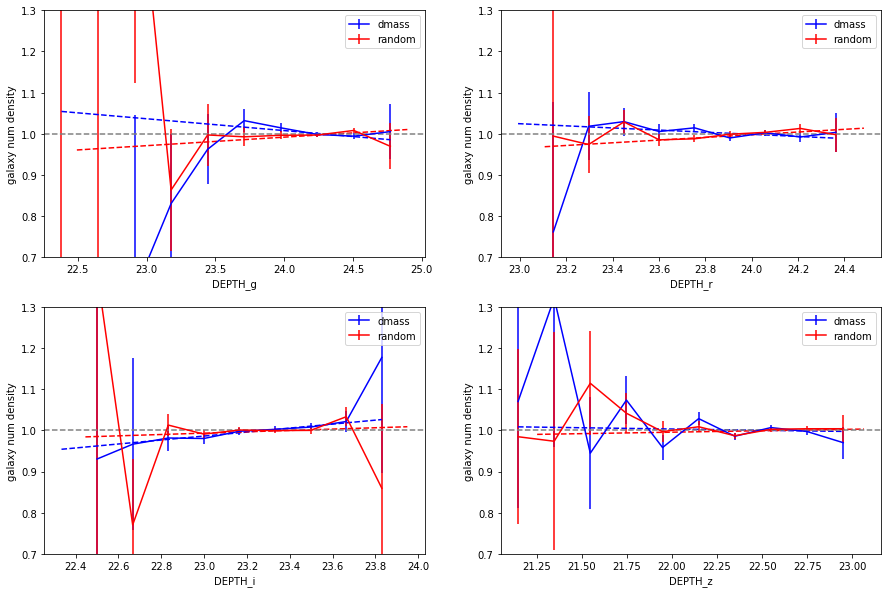

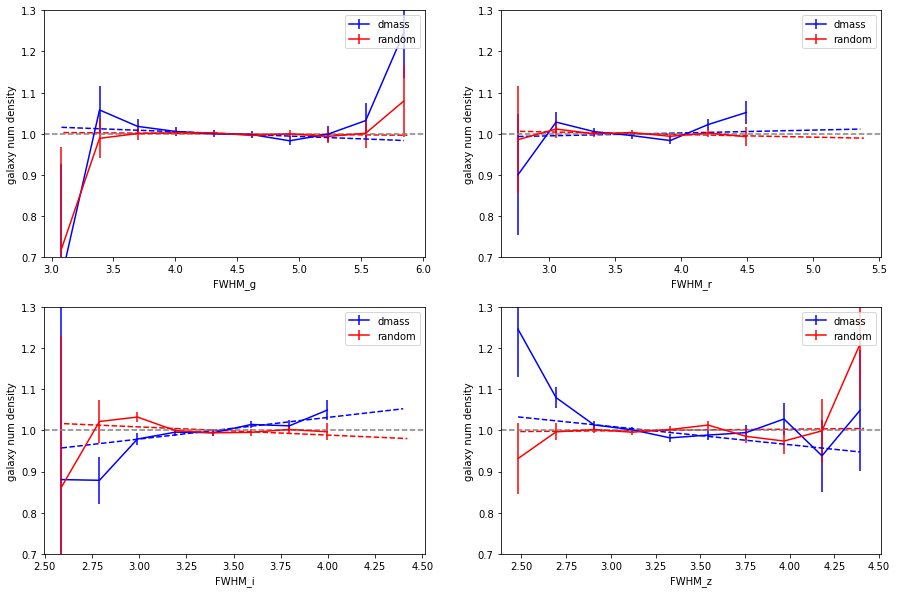

In [222]:
path = '../data_txt/systematics/exp_ri_fwhm_r_mask/'
suffix = 'wg_fwhm_r'
kind = 'SPT'
fitting_SP( property = ['AIRMASS', 'DEPTH', 'FWHM'], filter=['g','r','i','z'], kind = kind, suffix=suffix, plot=True, path=path
          , function = 'linear')

Delta chi2 (sample) = 2.0130456312278273
Delta chi2 (random) = 2.1191390759185103
Delta_chi2_68 =  1.441014571624587
significance =  1.3969641049211166
output save to  ../data_txt/systematics/exp_ri_fwhm_r_mask/systematic_EXPTIME_g_SPT_wg_fwhm_r.txt.model

Delta chi2 (sample) = 0.4370987316325685
Delta chi2 (random) = 2.379300088128966
Delta_chi2_68 =  1.6179240599276972
significance =  0.2701602272062768
output save to  ../data_txt/systematics/exp_ri_fwhm_r_mask/systematic_EXPTIME_r_SPT_wg_fwhm_r.txt.model

Delta chi2 (sample) = 0.23745909206840743
Delta chi2 (random) = 1.7793621897634375
Delta_chi2_68 =  1.2099662890391376
significance =  0.19625265118500054
output save to  ../data_txt/systematics/exp_ri_fwhm_r_mask/systematic_EXPTIME_i_SPT_wg_fwhm_r.txt.model

Delta chi2 (sample) = 0.6101216149485502
Delta chi2 (random) = 0.6923824717527003
Delta_chi2_68 =  0.47082008079183624
significance =  1.2958699933155642
output save to  ../data_txt/systematics/exp_ri_fwhm_r_mask/systematic_EX

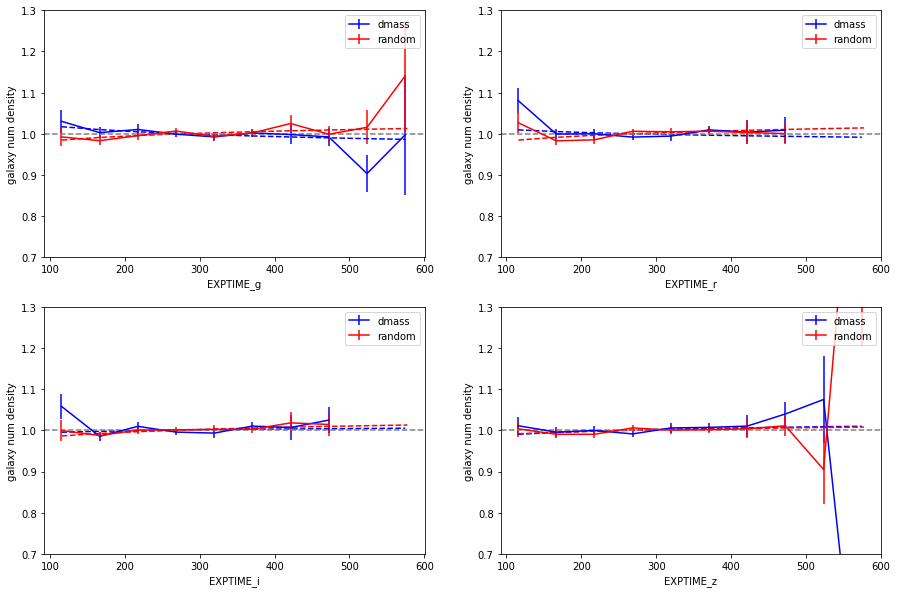

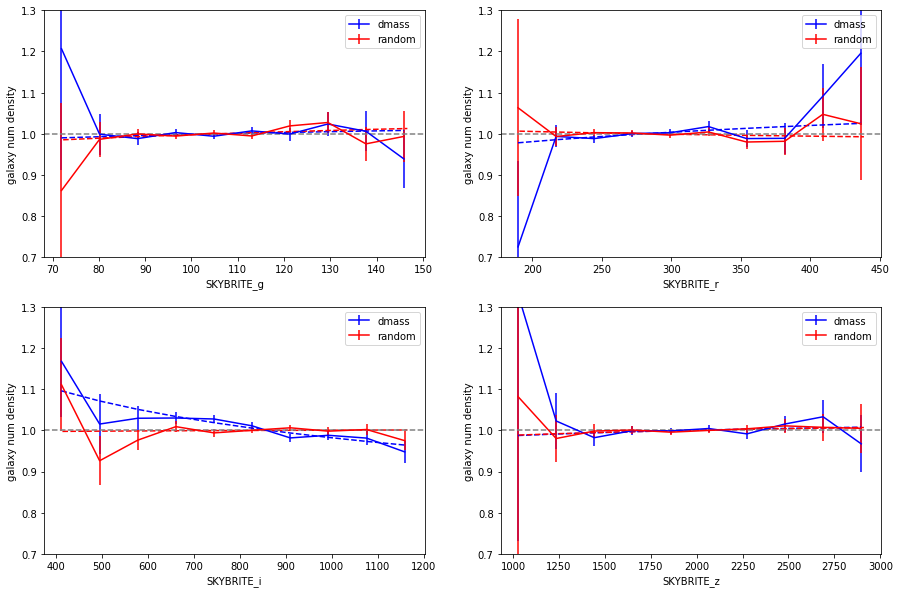

In [1112]:
fitting_SP( property = ['EXPTIME','SKYBRITE'], filter=['g','r','i','z'], kind = kind, suffix=suffix, plot=True, path=path
          , function = 'sqrt')

[742.8669952553738, 51.73657246711879, 11.099115565205516, 9.291638976723844, 8.708754484450386, 5.8655374107034595, 3.3674186897218137, 2.085516216664307, 1.3969641049211166, 1.2958699933155642, 1.2868811712839352, 0.6630933461710883, 0.6036721699964417, 0.47817442325472603, 0.2701602272062768, 0.19625265118500054]


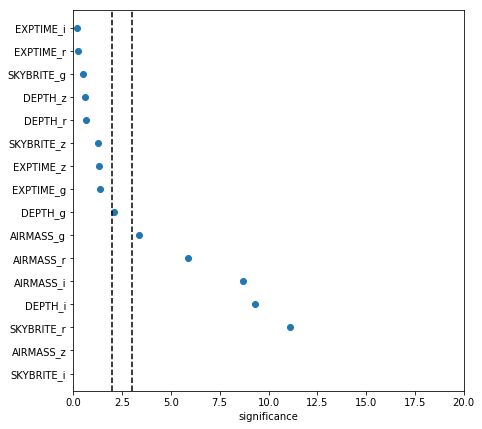

In [1115]:
path = '../data_txt/systematics/exp_ri_fwhm_r_mask/'
suffix = 'wg_fwhm_r'
plotting_significance( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE'], filter=['g', 'r', 'i','z'], 
                      kind = kind, suffix=suffix, path = path)

<Container object of 3 artists>

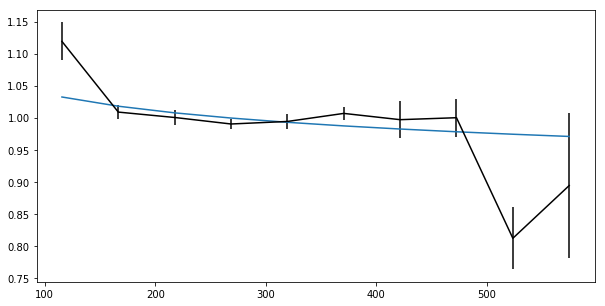

In [369]:

_, y_predict = fitting_linear( Cbins, Cdensity, Cerr)

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(Cbins, y_predict)     # Fit
ax.errorbar(Cbins, Cdensity, yerr=Cerr, fmt='k-')  # Data

In [555]:
#Assign weights to each galaxy
catHpInd = hpRaDecToHEALPixel(dmass_spt['RA'], dmass_spt['DEC'], nside=nside, nest = False)
bin_num = Cbins.size
step = (bins[2] - bins[1])
bin_center, binned_cat, keeps = divide_bins( sysMap, Tag = 'SIGNAL', min = Cbins.min() - step/2., max = Cbins.max() + step/2., bin_num = bin_num )

wg = np.zeros( dmass_spt.size, dtype=float)
for i, sysMap_i in enumerate(binned_cat):
    HpIdxInSys_mask = np.in1d(catHpInd, sysMap_i['PIXEL'])
    wg[HpIdxInSys_mask] = w_fwhm[i]

In [581]:
Cbins[Cbins < 5.0]

array([ 2.72814703,  2.94273138,  3.15731573,  3.37190008,  3.58648443,
        3.80106878,  4.01565313,  4.23023748,  4.44482183,  4.65940619,
        4.87399054])

(0.7, 1.5)

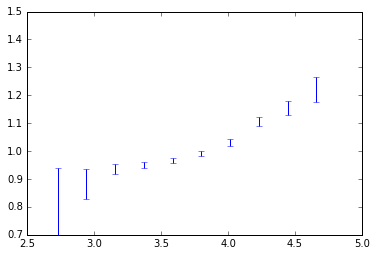

In [584]:
data_mask = Cbins < 5.0

fig, ax = plt.subplots()
ax.errorbar(Cbins[data_mask], Cdensity[data_mask], yerr = Cerr[data_mask], color ='blue', fmt='none')
#ax.errorbar(Rbins, Rdensity, yerr = Rerr, color = 'red')
#ax.plot(Cbins, y_predict, 'b--')
#ax.plot(bins, y_predict_R, 'r--')
ax.set_ylim(0.7, 1.5)


In [524]:

properties = ['FWHM']

#properties = ['NSTARS']
kind = 'SPT'
FullArea = SPTMaparea
#def CalculteGalaxyNgal(data, ):

# calculating galaxy density and weights iterately
from systematics import ReciprocalWeights, jksampling

for p in properties:
    if p is 'NSTARS':
        nside = 1024
        filter = ['g']
    else :
        nside = nside
        filter = ['g', 'r', 'i', 'z']
    for j,f in enumerate(filter):

        mapname = 'sys_'+p+'_'+f+'_'+kind #+'_masked'
        bins, Bdensity, Berr, Bf_area = GalaxyDensity_Systematics(dmass_spt2, MaskDic_fwhm[mapname], rand = rand_bg, nside = nside,\
                                                                    property = p, filter = f, FullArea = FullArea, reweight = wg)
        bins, Rdensity, Rerr, Rf_area = GalaxyDensity_Systematics(rand, MaskDic_fwhm[mapname], rand = rand_bg, nside = nside,\
                                                                    property = p, filter = f, FullArea = FullArea)
        #B_jkerr = jksampling(clean_dmass, MaskDic[mapname], property = p, nside = nside, njack = 30, raTag = 'RA', decTag = 'DEC' )
        filename = 'data_txt/systematic_'+p+'_'+f+'_'+kind+'_seeing'+'.txt'
        DAT = np.column_stack(( bins, Bdensity, Berr, Bf_area, Rdensity, Rerr, Rf_area  ))
        np.savetxt(filename, DAT, delimiter = ' ', header = 'bins, Cdensity, Cerr, Cfarea, Rdensity, Rerr, Rfarea, R_jkerr')
        print "saving data to ", filename

KeyboardInterrupt: 

saving fig to  figure/systematic_FWHM_SPT_seeing.png


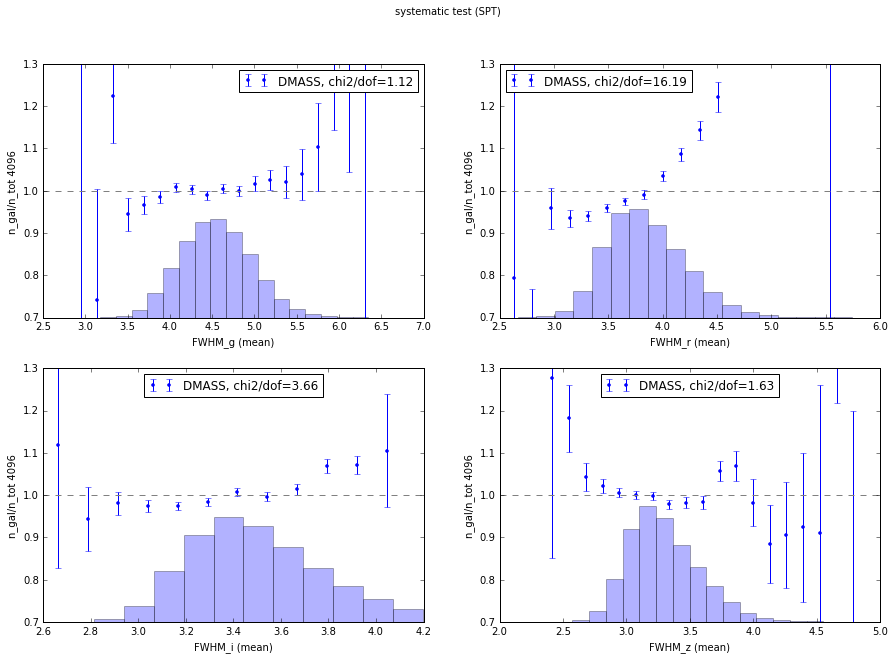

In [508]:
#properties = ['AIRMASS', 'SKYBRITE', 'FWHM', 'SKYSIGMA', 'NSTARS']
for p in properties:
    doVisualization_ngal(property = p, nside = 4096, kind = 'SPT', suffix='_seeing')

In [525]:
# calling catalog
from systematics import GalaxyDensity_Systematics,loadSystematicMaps, chisquare_dof, MatchHPArea, SysMapBadRegionMask, callingEliGoldMask

kind = 'SPT'
nside = 4096

properties = ['FWHM']
#properties = ['SKYBRITE']
filter = ['g', 'r', 'i', 'z']

# Calling maps
MaskDic_fwhm = {}
for i,p in enumerate(properties):
    if p == 'NSTARS':
        filename =  'y1a1_gold_1.0.2_stars_nside1024.fits'
        sysMap = loadSystematicMaps( filename = filename, property = p, filter = 'g', nside = 1024 , kind = kind)
        if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
        elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
        mapname = 'sys_'+p+'_'+'g'+'_'+kind
        MaskDic_fwhm[mapname] = sysMap
    else :
        filter = ['g', 'r', 'i', 'z']
        filename = None

        for j,f in enumerate(filter):
            sysMap = loadSystematicMaps( filename = filename, property = p, filter = f, nside = nside , kind = kind)
            mapname = 'sys_'+p+'_'+f+'_'+kind
            MaskDic_fwhm[mapname] = sysMap


PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
DOWNGRADE =  4096


In [218]:
sysMap = loadSystematicMaps( property = 'FWHM', filter = 'i', nside = 4096 , kind = 'SPT', \
                                       path = '/n/des/lee.5922/data/systematic_maps/seeing_i_spt/')

Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT
downgrade  4096


In [279]:
path = '/n/des/lee.5922/data/systematic_maps/'
fitsio.write(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits', LSSGoldMask2, clobber=True)

In [421]:
path = '/n/des/lee.5922/data/systematic_maps/'
#LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
#LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits')
#LSSGoldmask = np.loadtxt(path+'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.dat')

In [416]:
sysMap = loadSystematicMaps( filename = None, property = 'FWHM', filter = 'i', nside = 4096 , kind = 'SPT', \
                                       path = '/n/des/lee.5922/data/systematic_maps/seeing_i_spt/')

Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT


In [406]:
path ='/n/des/lee.5922/data/systematic_maps/seeing_i_spt/'
filename = 'Y1A1NEW_COADD_SPT_band_i_FWHM/Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz'
#filename = 'Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_coaddweights3_mean.fits.gz'
sysMap_hp = hp.read_map( path+filename, nest=False)
#sysMap_ud = hp.ud_grade(sysMap_hp, nside_out = 4096 )

goodmask = hp.mask_good(sysMap_hp)
maskIndices = np.arange(sysMap_hp.size)
goodIndices = maskIndices[goodmask]
clean_map = sysMap_hp[goodmask]

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT


In [422]:
keep = np.in1d(sysMap['PIXEL'], LSSGoldmask['PIXEL'])
sysMap['SIGNAL'][keep].max()

3.9999997615814209